# 딥러닝 머신러닝을 이용하여 온실 내부 환경 예측 알고리즘을 만들고 비교 분석

- 전북대학교 원예학과 실험 온실에서 수집한 온실 내부 데이터와 기상청 ASOS에서 수집한 외부 환경 데이터를 이용함.

- 수집한 데이터는 1시간 단위 데이터임.

- 2023년 5월 10일 부터 2024년 3월 19일 까지의 데이터로 학습하고, 2024년 3월 20일 부터 27일 까지의 데이터를 테스트 데이터로 사용하여 평가함.

# LSTM을 이용하여 외부 환경 데이터로 온실 내부 환경 예측하기

- Window Size는 6로 설정하고 pred Window Size는 1로 설정함. 이는 지난 6시간 외부환경을 가지고 다음 1 시간의 온실 내부 환경을 예측해나감을 의미함. 각 timestep 마다 예측 결과를 도출할 수 있음.

- 날짜는 학습에 사용하지 않았음.

## 학습 및 테스트 데이터 선언

In [1]:
import pandas as pd

# 데이터 로드 및 전처리
df = pd.read_csv('/content/preprocessed_data.csv', parse_dates=['Date&Time']).set_index('Date&Time')
test_df = pd.read_csv('/content/test_data.csv', parse_dates=['Date&Time']).set_index('Date&Time')

test_df

inner_temp  inner_hum  inner_CO2  inner_PPF  out_radn_m  \
Date&Time                                                                      
2024-03-20 00:00:00         6.5         61        414          0        0.00   
2024-03-20 01:00:00         5.9         62        413          0        0.00   
2024-03-20 02:00:00         5.5         62        422          0        0.00   
2024-03-20 03:00:00         5.3         63        427          0        0.00   
2024-03-20 04:00:00         5.1         63        428          0        0.00   
...                         ...        ...        ...        ...         ...   
2024-03-27 09:00:00        11.1         52        426          0        1.16   
2024-03-27 10:00:00        15.5         43        420        536        1.80   
2024-03-27 11:00:00        18.0         36        418       1046        2.36   
2024-03-27 12:00:00        19.1         36        430        902        2.70   
2024-03-27 13:00:00        19.7         34        428        864        2.49   

                     out_temp  out_wind  out_hum  out_radn_w  
Date&Time                                                     
2024-03-20 00:00:00       4.1       1.7       61      0.0000  
2024-03-20 01:00:00       4.0       3.4       61      0.0000  
2024-03-20 02:00:00       3.8       3.3       65      0.0000  
2024-03-20 03:00:00       3.8       3.3       66      0.0000  
2024-03-20 04:00:00       3.8       3.1       66      0.0000  
...                       ...       ...      ...         ...  
2024-03-27 09:00:00       8.9       0.8       76    322.2248  
2024-03-27 10:00:00      11.7       1.1       67    500.0040  
2024-03-27 11:00:00      13.9       0.7       53    655.5608  
2024-03-27 12:00:00      15.2       1.2       56    750.0060  
2024-03-27 13:00:00      15.8       2.4       54    691.6722  

[182 rows x 9 columns]

## 모델 학습

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 0.0362 - val_loss: 0.0061
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0037 - val_loss: 0.0038
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

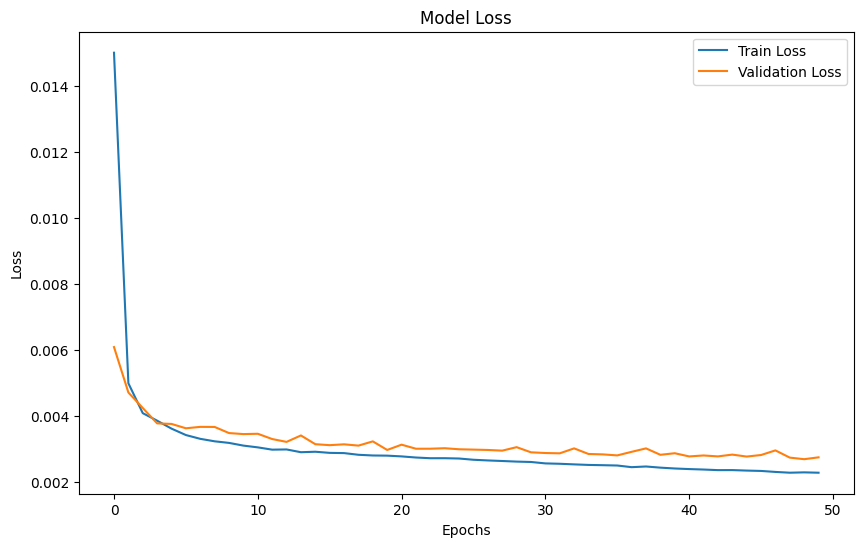

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape
import joblib
import matplotlib.pyplot as plt

# 데이터 컬럼 선택
out_columns = [col for col in df.columns if 'out' in col]
inner_columns = [col for col in df.columns if 'inner' in col]
all_columns = out_columns + inner_columns

# X = df[out_columns].values
X = df[all_columns].values
y = df[inner_columns].values

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 스케일러 저장
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# 윈도우 데이터 생성 함수 (이제 y를 다음 12시간 동안의 데이터로 설정)
def create_windowed_data(X, y, window_size, pred_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size - pred_size + 1):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size:i+window_size+pred_size])
    return np.array(Xs), np.array(ys)

window_size = 6
pred_size = 1
X_windowed, y_windowed = create_windowed_data(X_scaled, y_scaled, window_size, pred_size)
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_windowed, test_size=0.2, random_state=42)

# LSTM 모델 정의 (마지막 레이어의 뉴런 수를 pred_size로 설정)
model = Sequential()
model.add(LSTM(64, input_shape=(window_size, X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(pred_size * y_train.shape[2]))
model.add(Reshape((pred_size, y_train.shape[2])))

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))
model.save('lstm_model.h5')

# loss 시각화
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 학습 결과 시각화

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


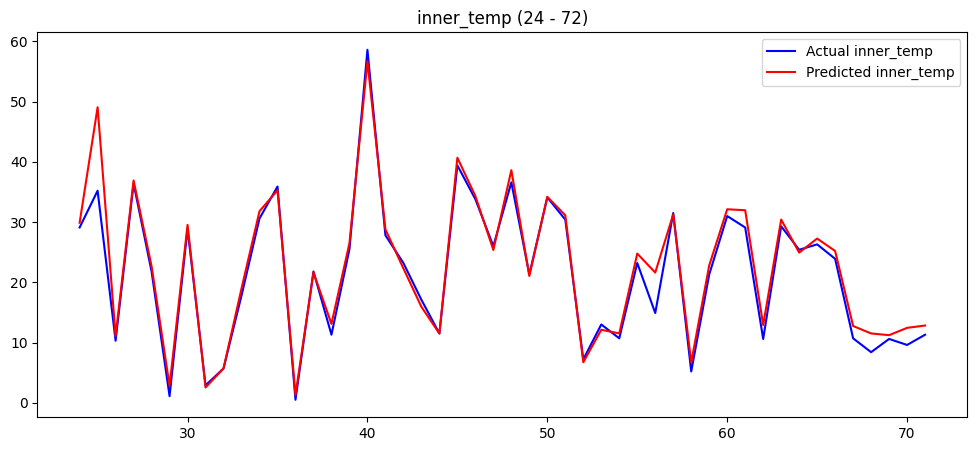

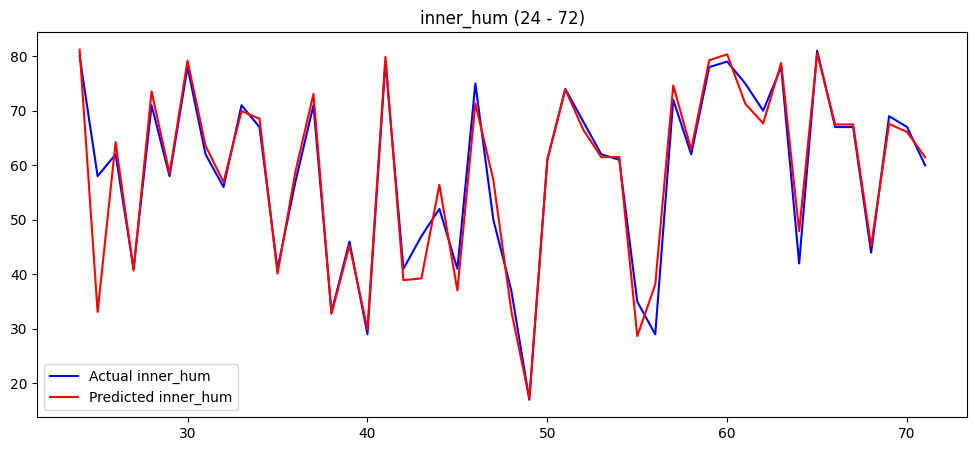

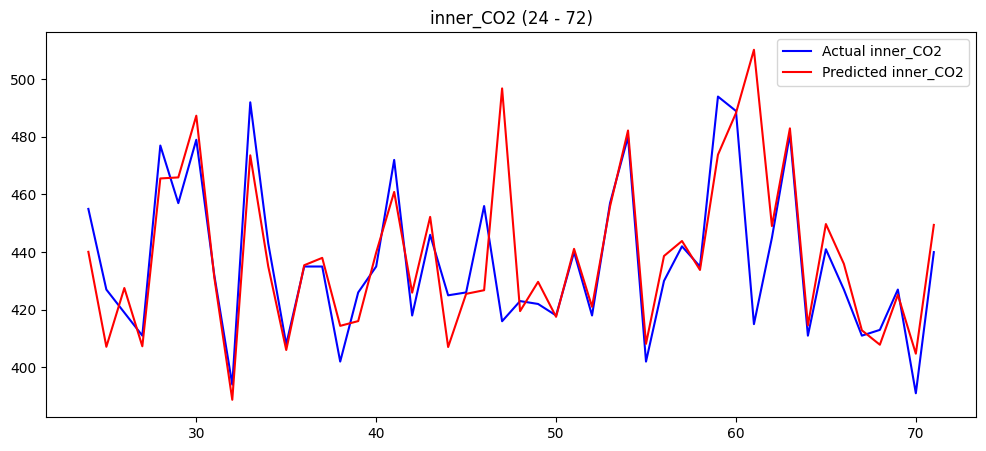

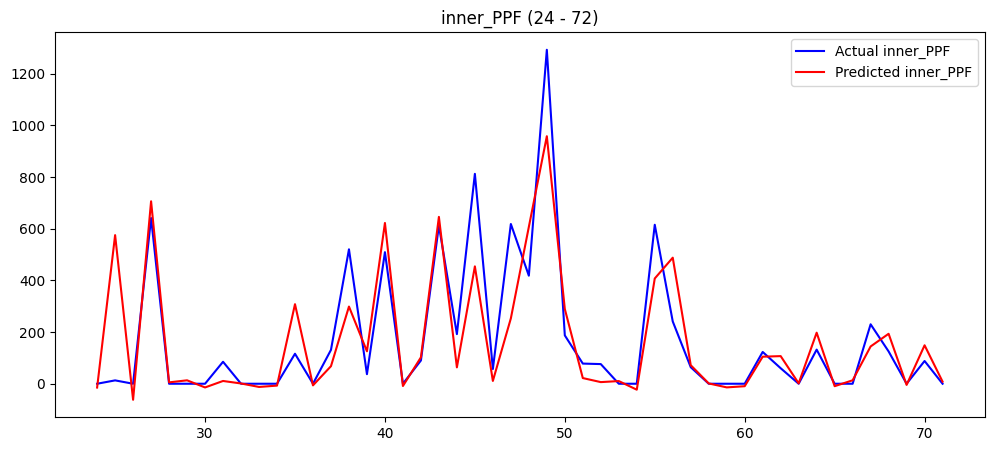

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_scaled = model.predict(X_test)
# print(y_pred_scaled.shape)
y_pred = scaler_y.inverse_transform(y_pred_scaled[:, -1, :])  # 마지막 타임스텝
y_test_actual_unscaled = scaler_y.inverse_transform(y_test[:, -1, :])  # 마지막 타임스텝

# 랜덤 샘플 추출 후 시각화
def plot_random_sample(y_test_actual, y_pred, inner_columns, sample_size):
    num_samples = y_test_actual.shape[0]
    start_index = np.random.randint(0, num_samples - sample_size)
    end_index = start_index + sample_size

    for i, column in enumerate(inner_columns):
        plt.figure(figsize=(12, 5))
        sns.lineplot(x=np.arange(start_index, end_index),
                     y=y_test_actual[start_index:end_index, i],
                     label=f'Actual {column}', color='blue')
        sns.lineplot(x=np.arange(start_index, end_index),
                     y=y_pred[start_index:end_index, i],
                     label=f'Predicted {column}', color='red')
        plt.title(f'{column} ({start_index} - {end_index})')
        plt.legend()
        plt.show()

plot_random_sample(y_test_actual_unscaled, y_pred, inner_columns, sample_size=48)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


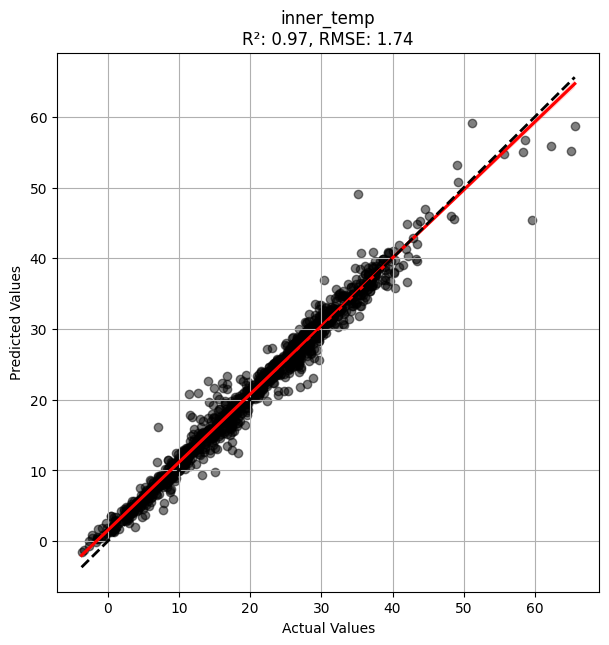

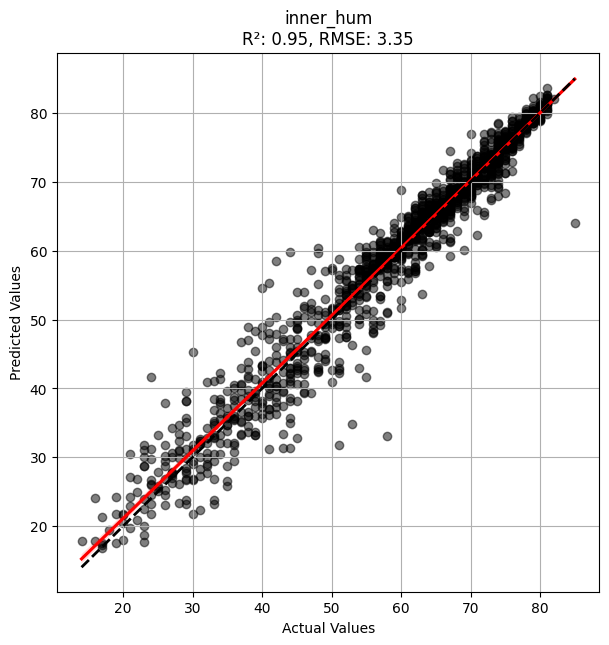

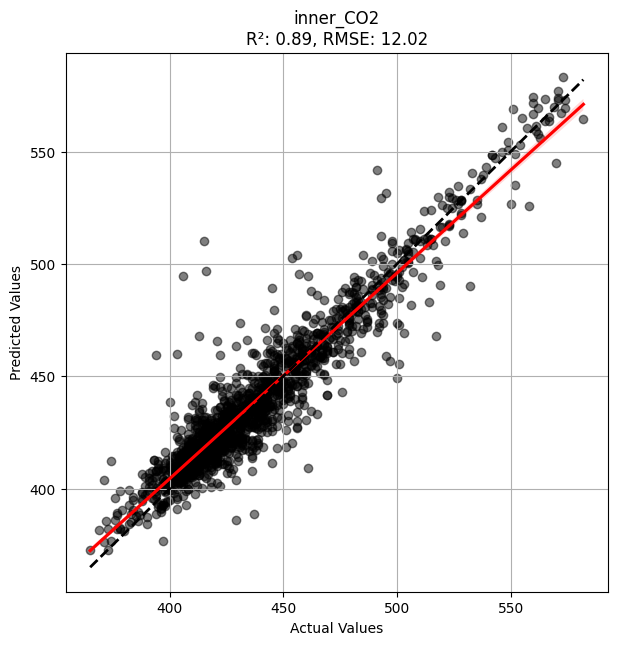

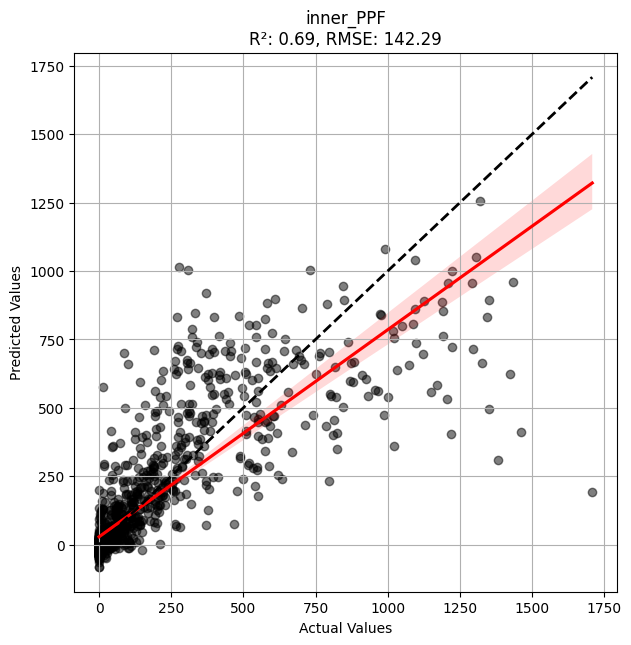

In [4]:
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled[:, -1, :])  # 마지막 타임스텝
y_test_actual_unscaled = scaler_y.inverse_transform(y_test[:, -1, :])  # 마지막 타임스텝

def plot_full_test_with_metrics(y_test_actual, y_pred, inner_columns, alpha=0.5):
    for i, column in enumerate(inner_columns):
        actual = y_test_actual[:, i]
        predicted = y_pred[:, i]

        r2 = r2_score(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))

        plt.figure(figsize=(7, 7))
        sns.regplot(x=actual, y=predicted, scatter_kws={'alpha': alpha, 'color': 'black'}, line_kws={'color': 'red'})
        plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'k--', lw=2)
        plt.title(f'{column}\nR²: {r2:.2f}, RMSE: {rmse:.2f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.grid(True)
        plt.show()

plot_full_test_with_metrics(y_test_actual_unscaled, y_pred, inner_columns)


## 테스트 데이터를 이용한 모델 검증

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


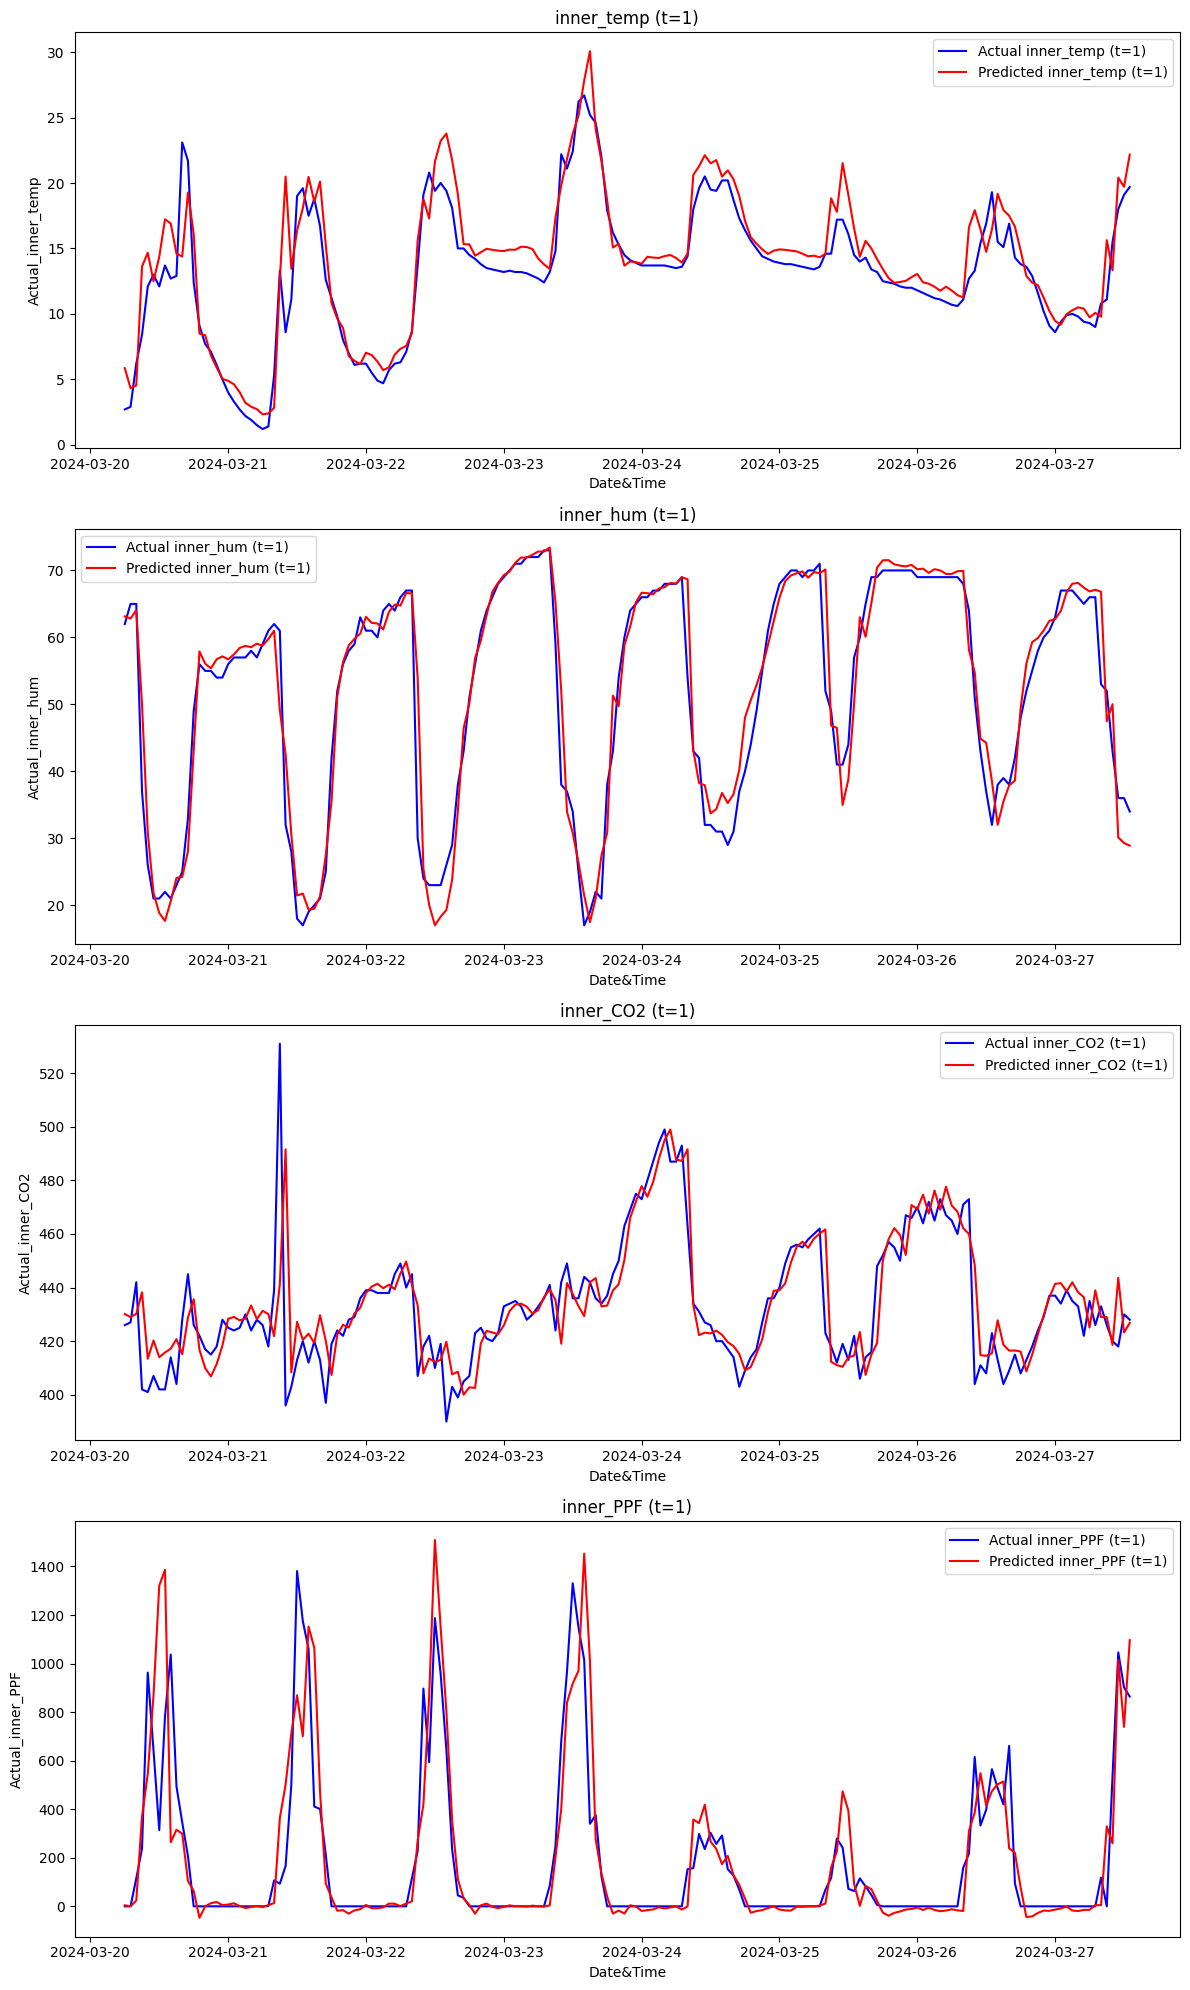

Actual_inner_temp  Actual_inner_hum  Actual_inner_CO2  \
Date&Time                                                                    
2024-03-20 06:00:00                2.7              62.0             426.0   
2024-03-20 07:00:00                2.9              65.0             427.0   
2024-03-20 08:00:00                6.2              65.0             442.0   
2024-03-20 09:00:00                8.4              37.0             402.0   
2024-03-20 10:00:00               12.1              26.0             401.0   

                     Actual_inner_PPF  Predicted_inner_temp  \
Date&Time                                                     
2024-03-20 06:00:00               0.0              5.854596   
2024-03-20 07:00:00               0.0              4.326275   
2024-03-20 08:00:00             115.0              4.531692   
2024-03-20 09:00:00             238.0             13.622413   
2024-03-20 10:00:00             963.0             14.670341   

                     Predicted_inner_hum  Predicted_inner_CO2  \
Date&Time                                                       
2024-03-20 06:00:00            63.138252           430.121033   
2024-03-20 07:00:00            62.815598           428.984283   
2024-03-20 08:00:00            64.064064           430.184326   
2024-03-20 09:00:00            49.937016           438.238251   
2024-03-20 10:00:00            30.861240           413.440002   

                     Predicted_inner_PPF  
Date&Time                                 
2024-03-20 06:00:00             4.212881  
2024-03-20 07:00:00             0.097865  
2024-03-20 08:00:00            24.168425  
2024-03-20 09:00:00           369.805359  
2024-03-20 10:00:00           545.787292

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# 모델 및 스케일러 로드
model = load_model('/content/lstm_model.h5')
scaler_X = joblib.load('/content/scaler_X.pkl')
scaler_y = joblib.load('/content/scaler_y.pkl')

# 데이터 준비
out_columns = [col for col in test_df.columns if 'out' in col]
inner_columns = [col for col in test_df.columns if 'inner' in col]
all_columns = out_columns + inner_columns

X_test_new = test_df[all_columns].values
y_test_actual = test_df[inner_columns].values
X_test_new_scaled = scaler_X.transform(X_test_new)
y_test_actual_scaled = scaler_y.transform(y_test_actual)

X_test_windowed, y_test_windowed = create_windowed_data(X_test_new_scaled, y_test_actual_scaled, window_size, pred_size)

# 예측 수행
y_pred_scaled = model.predict(X_test_windowed)
y_pred_unscaled = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, y_pred_scaled.shape[-1]))

# 실제 테스트 데이터 스케일링 역변환
y_test_actual_unscaled = scaler_y.inverse_transform(y_test_windowed.reshape(-1, y_test_windowed.shape[-1]))

num_time_steps = y_test_windowed.shape[1]
num_inner_columns = y_test_windowed.shape[2]
last_time_step = num_time_steps - 1

# 예측 결과를 데이터프레임으로
dates = test_df.index[window_size + last_time_step:window_size + last_time_step + len(y_test_actual_unscaled[last_time_step::num_time_steps, 0])]

predicted_df = pd.DataFrame(y_pred_unscaled[last_time_step::num_time_steps], columns=[f'Predicted_{col}' for col in inner_columns], index=dates)
actual_df = pd.DataFrame(y_test_actual_unscaled[last_time_step::num_time_steps], columns=[f'Actual_{col}' for col in inner_columns], index=dates)
lstm_results = pd.concat([actual_df, predicted_df], axis=1)

# 결과 시각화
plt.figure(figsize=(12, 5 * num_inner_columns))
for i in range(num_inner_columns):
    plt.subplot(num_inner_columns, 1, i + 1)
    sns.lineplot(data=lstm_results, x=lstm_results.index, y=f'Actual_{inner_columns[i]}', label=f'Actual {inner_columns[i]} (t={last_time_step+1})', color='blue')
    sns.lineplot(data=lstm_results, x=lstm_results.index, y=f'Predicted_{inner_columns[i]}', label=f'Predicted {inner_columns[i]} (t={last_time_step+1})', color='red')
    plt.title(f'{inner_columns[i]} (t={last_time_step+1})')
    plt.legend()

plt.tight_layout()
plt.show()

# 결과 데이터프레임 출력
lstm_results.head()

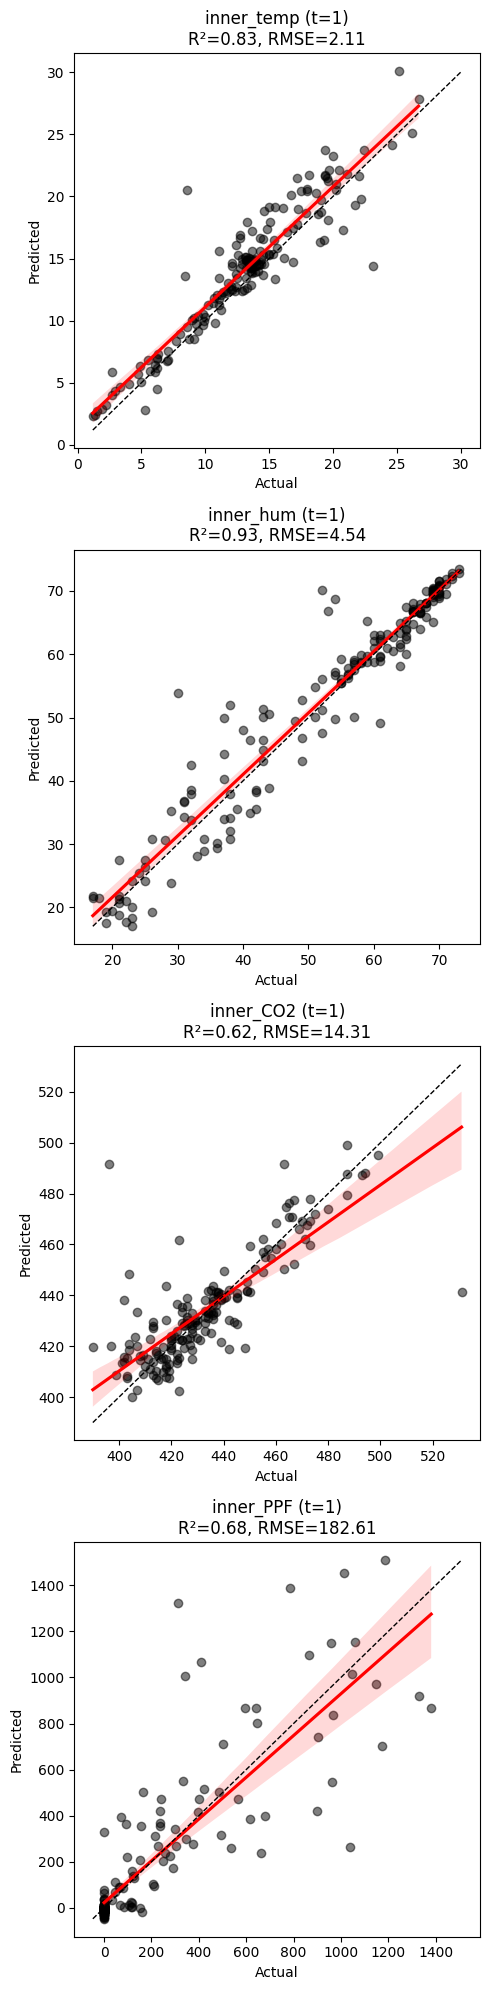

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

num_inner_columns = len(inner_columns)

# 시각화
plt.figure(figsize=(5, 5 * num_inner_columns))
for i in range(num_inner_columns):
    plt.subplot(num_inner_columns, 1, i + 1)

    actual = lstm_results[f'Actual_{inner_columns[i]}']
    predicted = lstm_results[f'Predicted_{inner_columns[i]}']

    r2 = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    sns.regplot(x=actual, y=predicted, scatter_kws={'color': 'black', 'alpha': 0.5}, line_kws={'color': 'red'})
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

    plt.title(f'{inner_columns[i]} (t={last_time_step+1})\nR²={r2:.2f}, RMSE={rmse:.2f}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

plt.tight_layout()
plt.show()

# Prophet으로 시계열 예측하기

- meta의 Prophet을 이용해서 온실 내부 환경 변수의 추세를 분석하고, 예측할 수 있음.

- 하나의 변수만을 가지고 예측하는데에 특화되어있음.

## Prophet model fitting

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzklrhqid/3cjpmm9i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzklrhqid/czk1rj07.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77346', 'data', 'file=/tmp/tmpzklrhqid/3cjpmm9i.json', 'init=/tmp/tmpzklrhqid/czk1rj07.json', 'output', 'file=/tmp/tmpzklrhqid/prophet_model2qhyuml0/prophet_model-20240819094258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:42:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:43:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, i

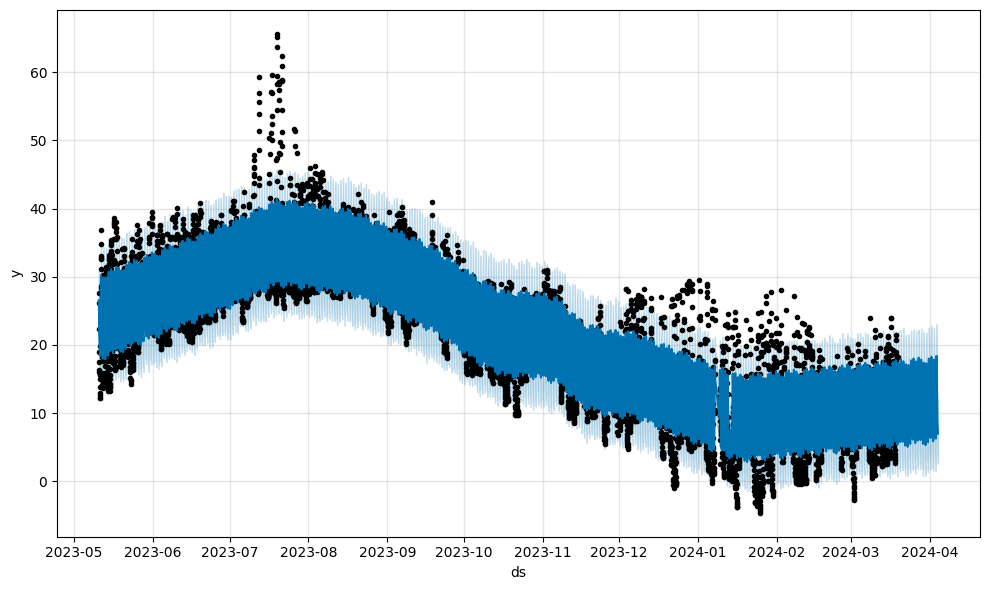

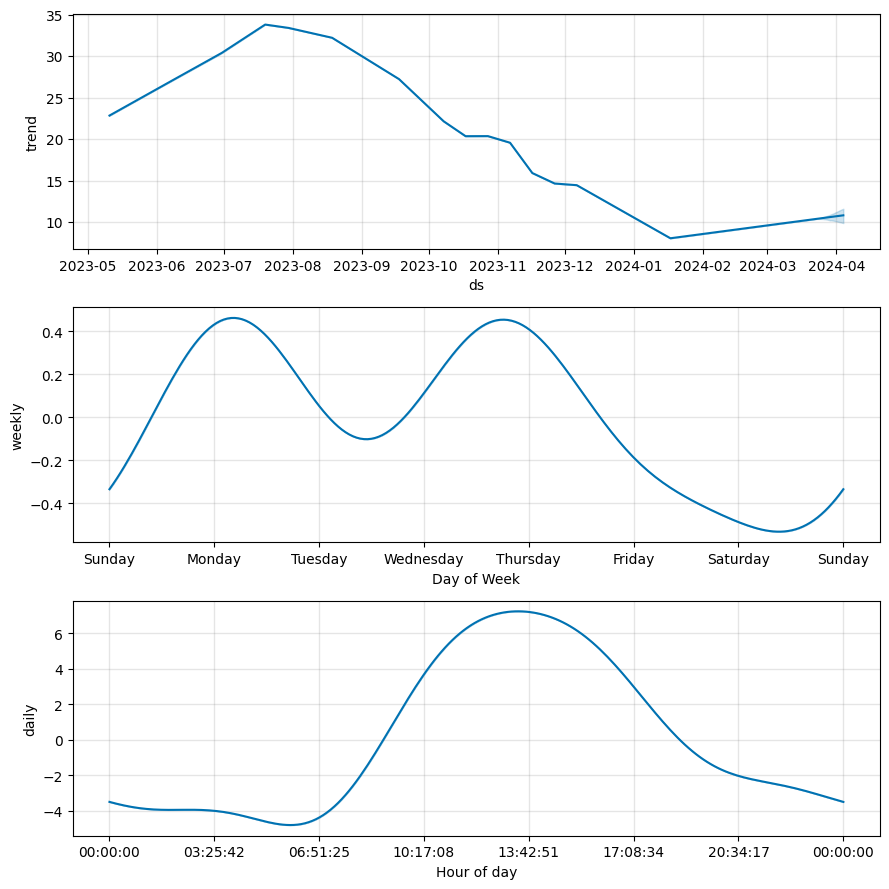

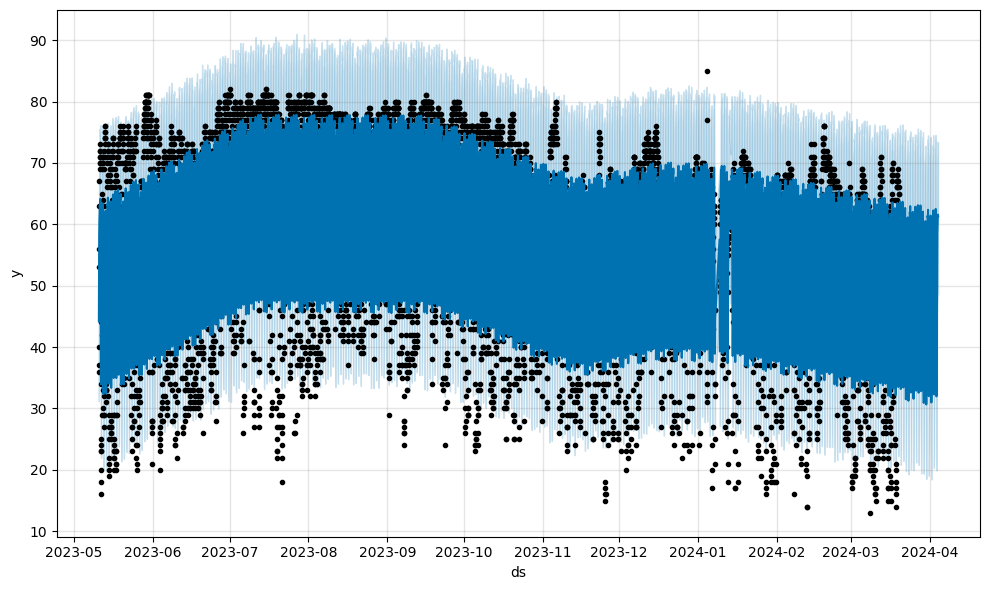

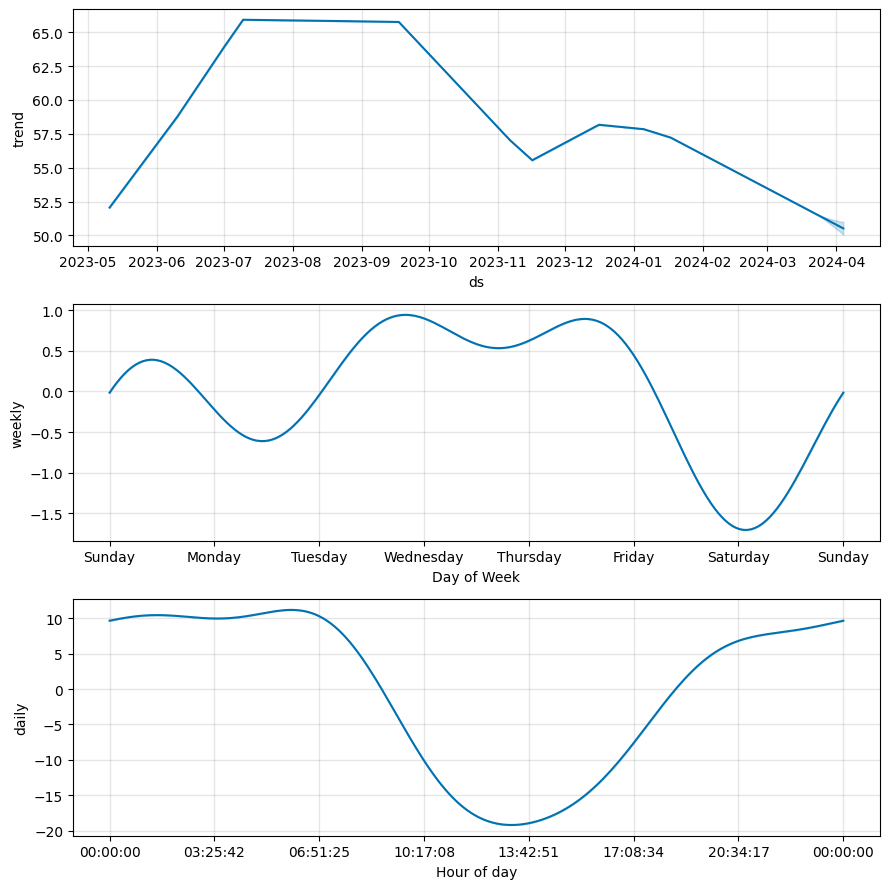

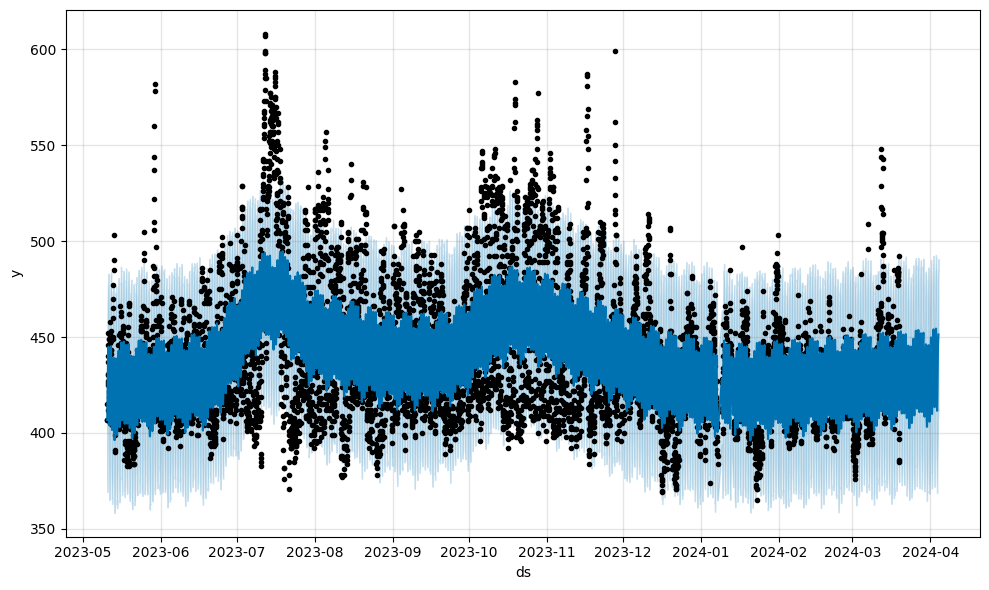

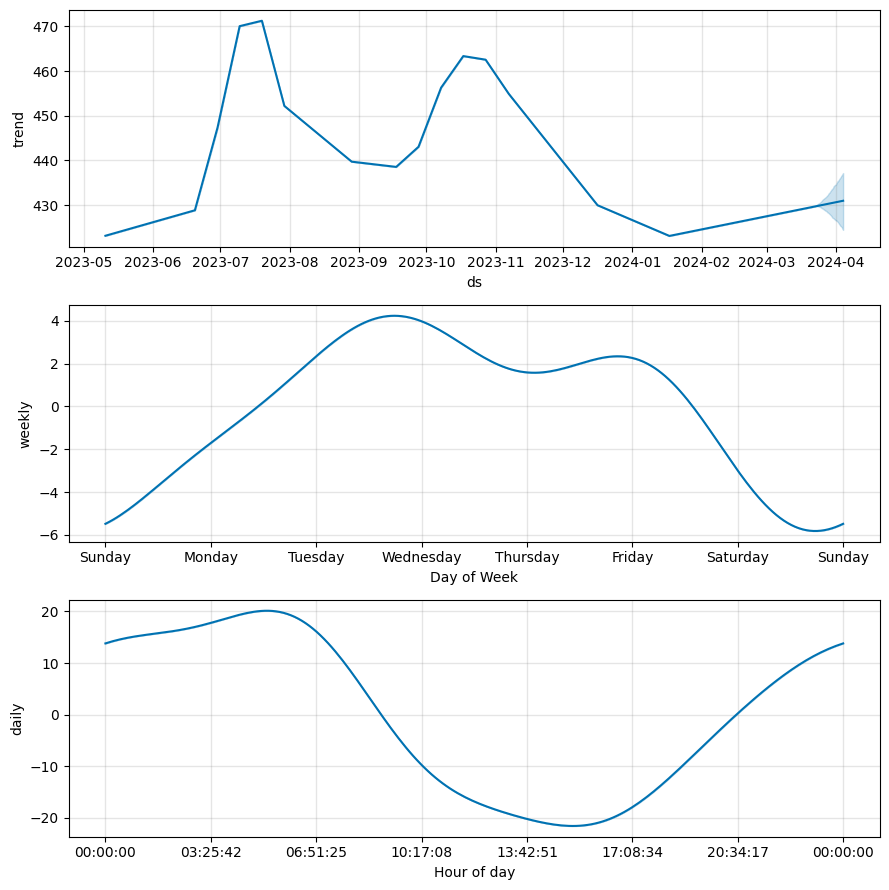

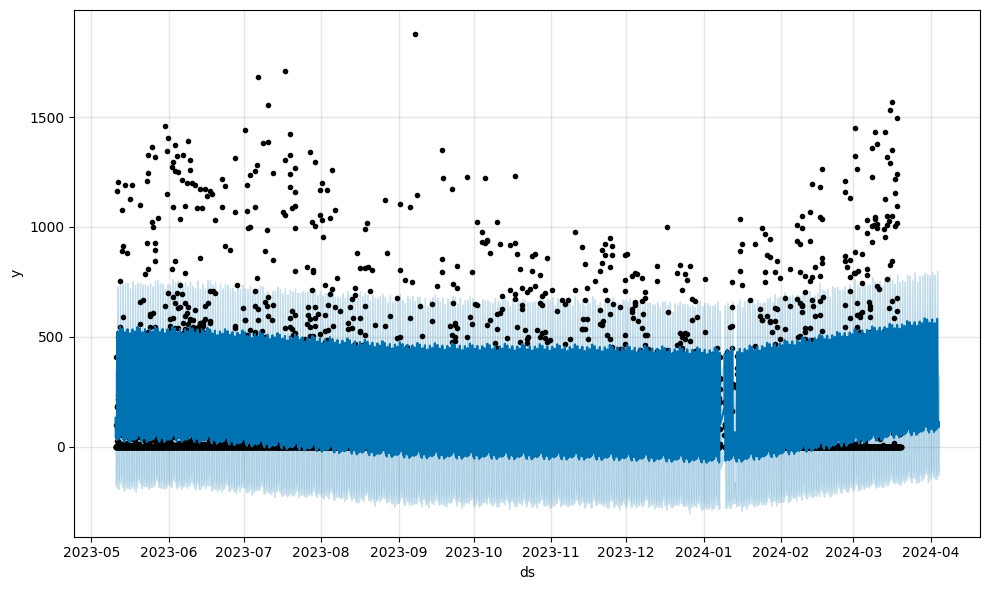

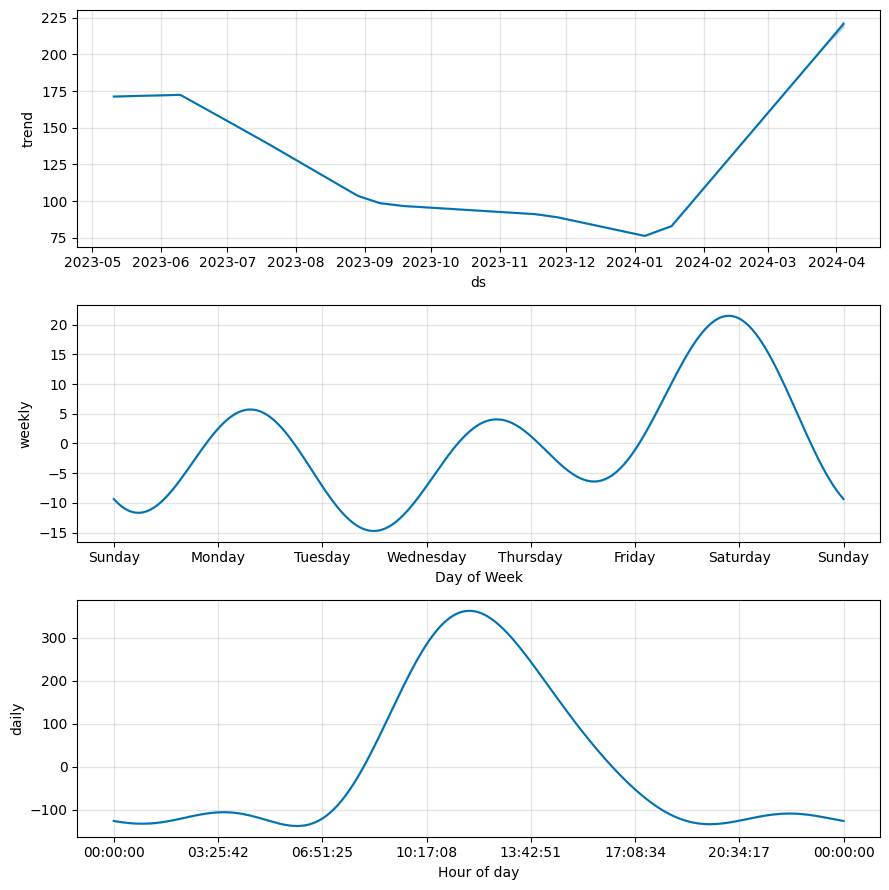

In [7]:
from prophet import Prophet
import pandas as pd

data = df.reset_index()
data['ds'] = pd.to_datetime(data['Date&Time'])
inner_columns = [col for col in data.columns if col.startswith('inner')]

all_forecasts = []
for column in inner_columns:
    temp_data = data[['ds', column]].rename(columns={column: 'y'})

    model = Prophet()
    model.fit(temp_data)

    future = model.make_future_dataframe(periods=365, freq='H')
    forecast = model.predict(future)

    fig1 = model.plot(forecast)
    fig2 = model.plot_components(forecast)

    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    forecast = forecast.rename(columns={
        'yhat': f'{column}_yhat',
        'yhat_lower': f'{column}_yhat_lower',
        'yhat_upper': f'{column}_yhat_upper'
    })

    forecast = forecast.set_index('ds')
    all_forecasts.append(forecast)

prophet_results = pd.concat(all_forecasts, axis=1).reset_index()
# print(prophet_results)

## 피팅 결과 시각화

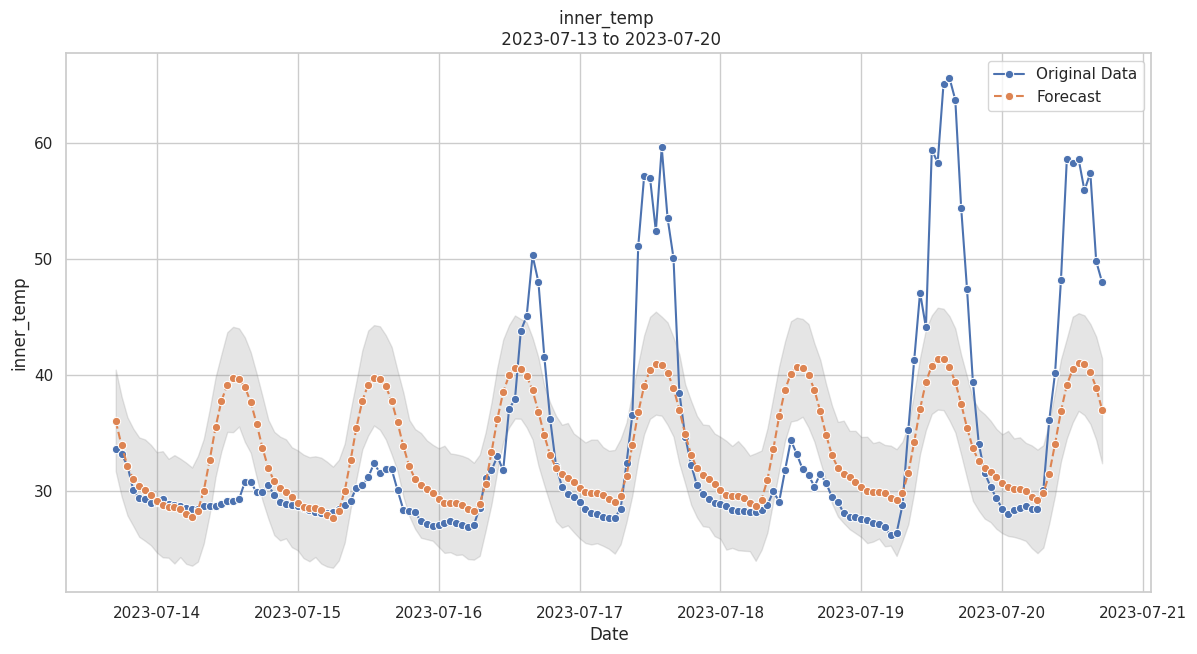

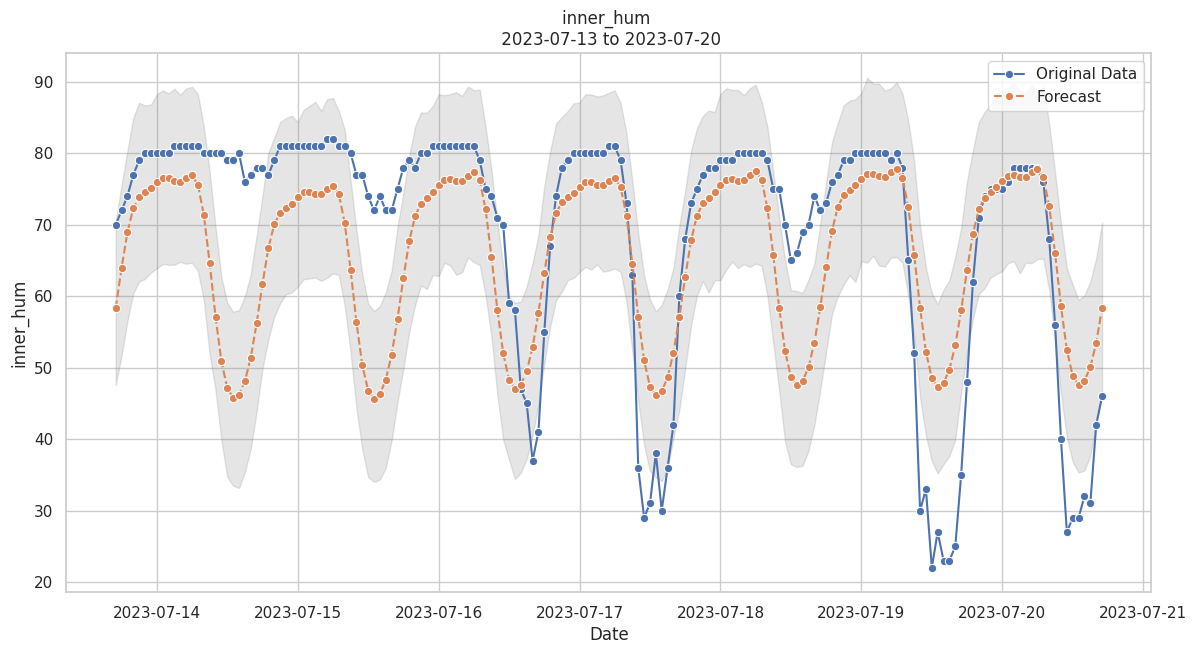

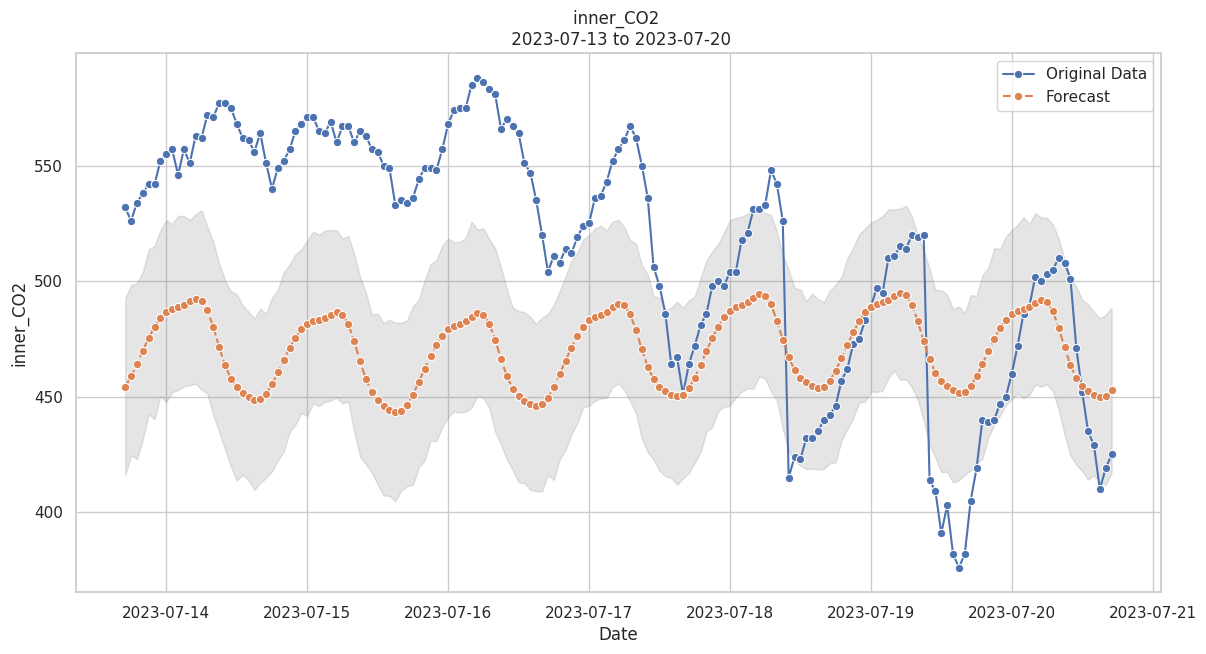

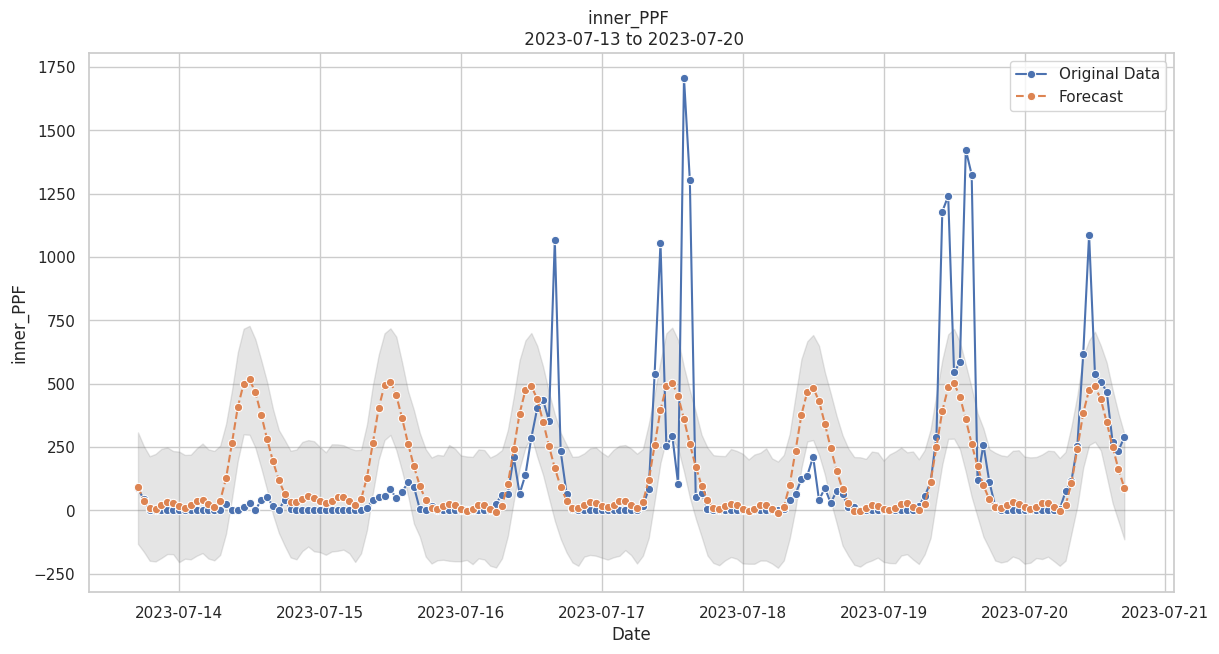

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import random

sns.set(style="whitegrid")

# 날짜 범위 선택
num_days = 7
start_date = random.choice(pd.date_range(start=data['ds'].min(), end=data['ds'].max() - pd.Timedelta(days=num_days)))
end_date = start_date + pd.Timedelta(days=num_days)

# 데이터 필터링
filtered_data = data[(data['ds'] >= start_date) & (data['ds'] <= end_date)]
filtered_forecast = prophet_results[(prophet_results['ds'] >= start_date) & (prophet_results['ds'] <= end_date)]
data_col = ['inner_temp', 'inner_hum', 'inner_CO2', 'inner_PPF',]


# 시각화
for col in data_col:
  plt.figure(figsize=(14, 7))
  sns.lineplot(x=filtered_data['ds'], y=filtered_data[col], label='Original Data', marker="o")
  sns.lineplot(x=filtered_forecast['ds'], y=filtered_forecast[f'{col}_yhat'], label='Forecast', linestyle='--', marker="o")
  plt.fill_between(filtered_forecast['ds'], filtered_forecast[f'{col}_yhat_lower'], filtered_forecast[f'{col}_yhat_upper'], color='gray', alpha=0.2)

  plt.xlabel('Date')
  plt.ylabel(col)
  plt.title(f'{col} \n {start_date.date()} to {end_date.date()}')
  plt.legend()
  plt.grid(True)
  plt.show()


# ML 이용해서 내부 환경 예측하기

- 트리기반 모델인 RandomForest와 XGBoost를 stacking한 Ensemble 모델을 이용하여 외부기상으로 온실 내부 환경을 예측하는 모델

## 모델 학습

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib


out_columns = [col for col in df.columns if 'out' in col]
inner_columns = [col for col in df.columns if 'inner' in col]

out_features = df[out_columns]
inner_targets = df[inner_columns]

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(out_features, inner_targets, test_size=0.2, random_state=42)

# 스케일링 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), out_features.columns)
    ])

# 모델 정의
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# 앙상블 모델 정의 (Stacking)
ensemble_model = StackingRegressor(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

# 각 타겟 변수에 대해 모델을 학습 및 저장
for column in inner_columns:
    # 파이프라인 구성
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', ensemble_model)])

    # 해당 타겟 변수에 대해 학습
    pipeline.fit(X_train, y_train[column])

    # 모델 저장
    model_filename = f'model_{column}.pkl'
    joblib.dump(pipeline, model_filename)
    print(f'Model for {column} saved as {model_filename}')

    # 예측
    y_pred = pipeline.predict(X_test)

    # 성능 평가
    mse = mean_squared_error(y_test[column], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[column], y_pred)

    print(f'Target: {column}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}\n')


Model for inner_temp saved as model_inner_temp.pkl
Target: inner_temp
MSE: 7.683626884556
RMSE: 2.7719355844889324
R2: 0.9331347034287272

Model for inner_hum saved as model_inner_hum.pkl
Target: inner_hum
MSE: 21.66346760999926
RMSE: 4.654403034761736
R2: 0.9084780382580032

Model for inner_CO2 saved as model_inner_CO2.pkl
Target: inner_CO2
MSE: 910.3789000555926
RMSE: 30.172485811672736
R2: 0.3406902453480293

Model for inner_PPF saved as model_inner_PPF.pkl
Target: inner_PPF
MSE: 23564.745909672714
RMSE: 153.50812978364604
R2: 0.5645174966460476



## 모델 검증 및 시각화

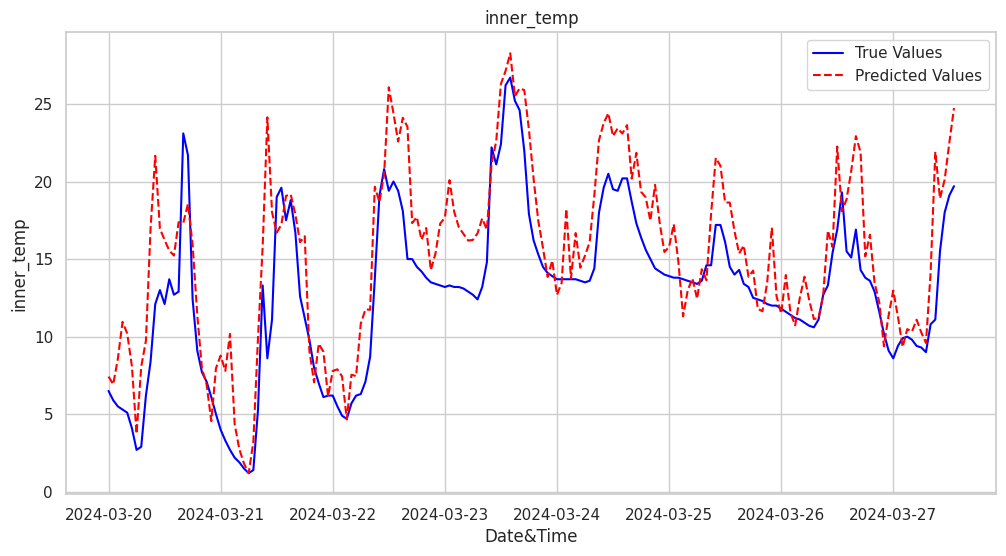

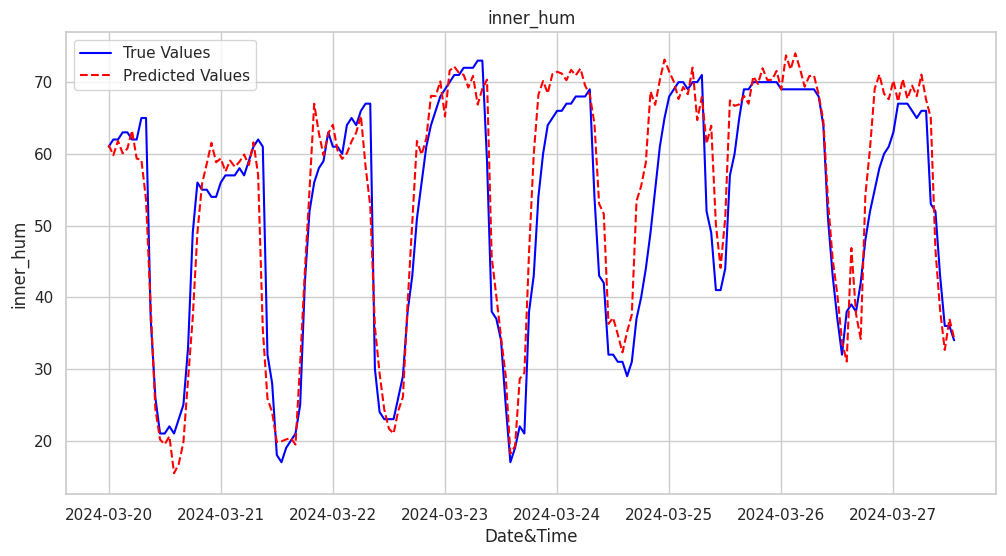

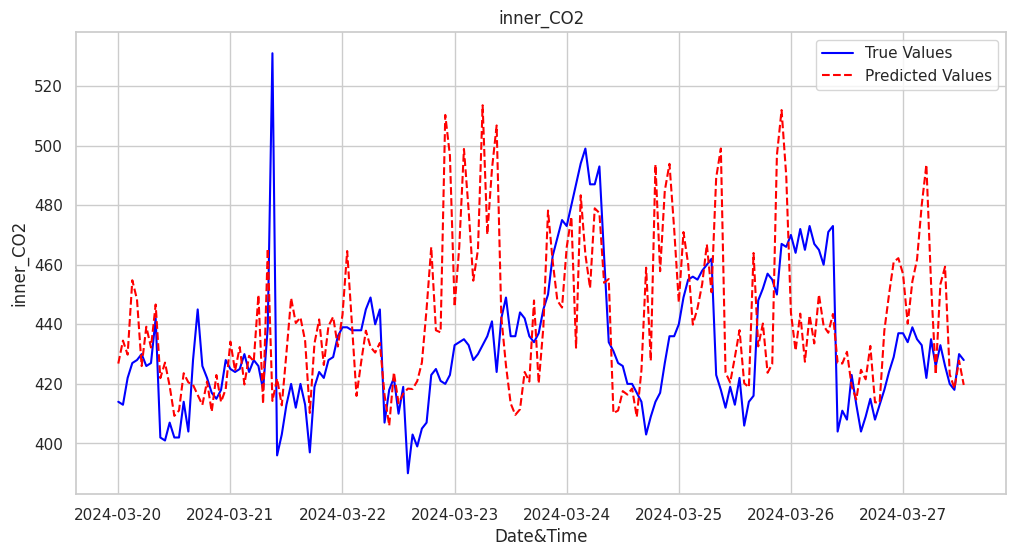

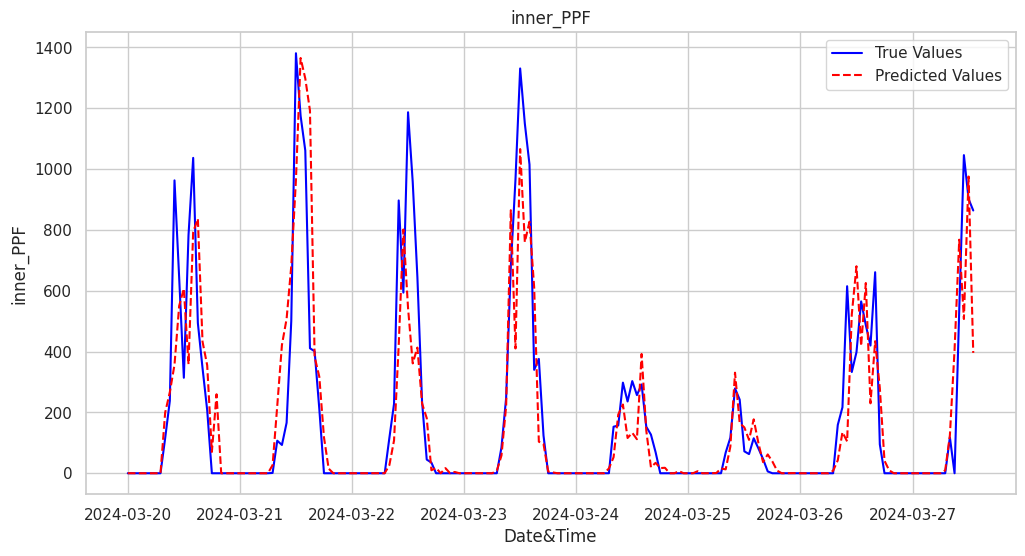

In [10]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

out_columns = [col for col in test_df.columns if 'out' in col]
ml_results = pd.DataFrame(index=test_df.index)

# 각 타겟 변수에 대한 모델로 예측
for column in inner_columns:
    model_filename = f'model_{column}.pkl'
    loaded_model = joblib.load(model_filename)
    ml_results[column] = loaded_model.predict(test_df[out_columns])


# 시각화
sns.set(style="whitegrid")

def plot_predictions(true_values, predicted_values, column_name):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=true_values.index, y=true_values, label='True Values', color='blue', linestyle='-')
    sns.lineplot(x=predicted_values.index, y=predicted_values, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'{column_name}')
    plt.ylabel(column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

for column in inner_columns:
    plot_predictions(test_df[column], ml_results[column], column)


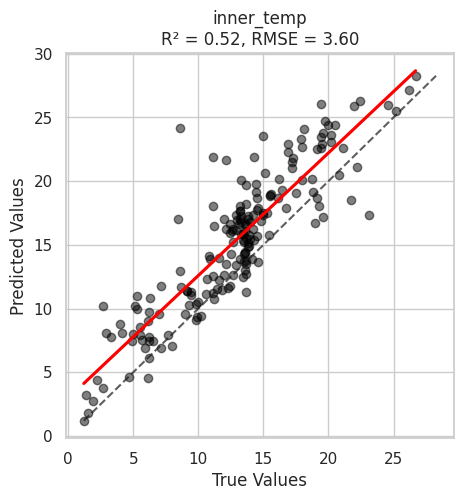

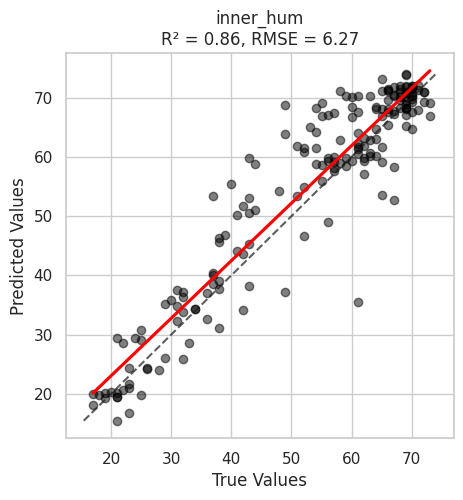

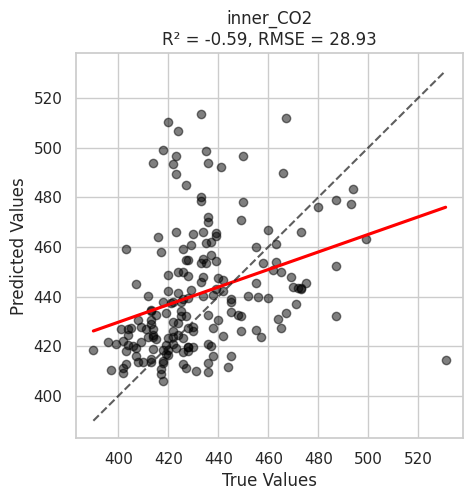

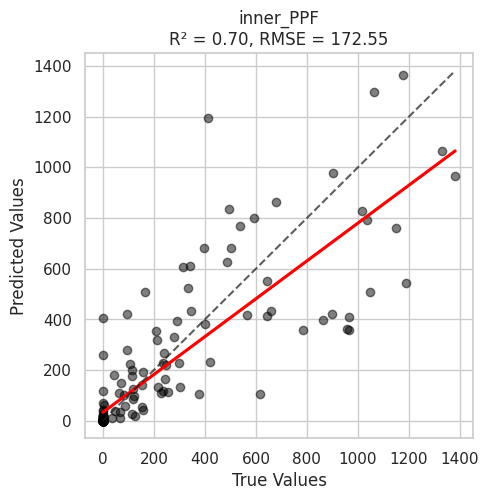

In [11]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

out_columns = [col for col in test_df.columns if 'out' in col]
ml_results = pd.DataFrame(index=test_df.index)

for column in inner_columns:
    model_filename = f'model_{column}.pkl'
    loaded_model = joblib.load(model_filename)
    ml_results[column] = loaded_model.predict(test_df[out_columns])

# 시각화 설정
sns.set(style="whitegrid")

def plot_predictions_with_regression(true_values, predicted_values, column_name):
    r2 = r2_score(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

    plt.figure(figsize=(5, 5))
    sns.regplot(x=true_values, y=predicted_values, scatter_kws={'color': 'black', 'alpha': 0.5},
                line_kws={'color': 'red'}, ci=None)

    max_val = max(true_values.max(), predicted_values.max())
    min_val = min(true_values.min(), predicted_values.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)

    plt.title(f'{column_name}\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')

    plt.grid(True)
    plt.show()

for column in inner_columns:
    plot_predictions_with_regression(test_df[column], ml_results[column], column)

# ML Dummies를 이용하여 내부 환경 예측하기

- 마찬가지로 트리기반 모델인 RandomForest와 XGBoost를 이용하되, 전과는 다르게 외부환경만에 일정 시간 이전의 내부환경(dummies)을 입력자료로 활용하여 예측하도록 구성

## 데이터 전처리(이전 시간의 내부환경 시프트)

In [12]:
import pandas as pd

def preprocess_features(df, shift_size):
    data = df
    out_columns = [col for col in data.columns if 'out' in col]
    inner_columns = [col for col in data.columns if 'inner' in col]
    out_features = data[out_columns]

    shifted_inner_features = data[inner_columns].shift(shift_size).fillna(method='bfill')
    shifted_inner_features.columns = [f"{col.split('_')[1]}_shifted" for col in inner_columns]

    final_features = pd.concat([out_features, data[inner_columns], shifted_inner_features], axis=1)
    final_features = final_features.iloc[shift_size:]

    return final_features

shift_size = 3
processed_data = preprocess_features(df, shift_size)
test_data = preprocess_features(test_df, shift_size)

test_data

<ipython-input-12-d52c810db20d>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  shifted_inner_features = data[inner_columns].shift(shift_size).fillna(method='bfill')
<ipython-input-12-d52c810db20d>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  shifted_inner_features = data[inner_columns].shift(shift_size).fillna(method='bfill')


out_radn_m  out_temp  out_wind  out_hum  out_radn_w  \
Date&Time                                                                  
2024-03-20 03:00:00        0.00       3.8       3.3       66      0.0000   
2024-03-20 04:00:00        0.00       3.8       3.1       66      0.0000   
2024-03-20 05:00:00        0.00       3.2       2.6       65      0.0000   
2024-03-20 06:00:00        0.00       2.1       0.9       69      0.0000   
2024-03-20 07:00:00        0.01       2.2       1.1       66      2.7778   
...                         ...       ...       ...      ...         ...   
2024-03-27 09:00:00        1.16       8.9       0.8       76    322.2248   
2024-03-27 10:00:00        1.80      11.7       1.1       67    500.0040   
2024-03-27 11:00:00        2.36      13.9       0.7       53    655.5608   
2024-03-27 12:00:00        2.70      15.2       1.2       56    750.0060   
2024-03-27 13:00:00        2.49      15.8       2.4       54    691.6722   

                     inner_temp  inner_hum  inner_CO2  inner_PPF  \
Date&Time                                                          
2024-03-20 03:00:00         5.3         63        427          0   
2024-03-20 04:00:00         5.1         63        428          0   
2024-03-20 05:00:00         4.1         62        430          0   
2024-03-20 06:00:00         2.7         62        426          0   
2024-03-20 07:00:00         2.9         65        427          0   
...                         ...        ...        ...        ...   
2024-03-27 09:00:00        11.1         52        426          0   
2024-03-27 10:00:00        15.5         43        420        536   
2024-03-27 11:00:00        18.0         36        418       1046   
2024-03-27 12:00:00        19.1         36        430        902   
2024-03-27 13:00:00        19.7         34        428        864   

                     temp_shifted  hum_shifted  CO2_shifted  PPF_shifted  
Date&Time                                                                 
2024-03-20 03:00:00           6.5         61.0        414.0          0.0  
2024-03-20 04:00:00           5.9         62.0        413.0          0.0  
2024-03-20 05:00:00           5.5         62.0        422.0          0.0  
2024-03-20 06:00:00           5.3         63.0        427.0          0.0  
2024-03-20 07:00:00           5.1         63.0        428.0          0.0  
...                           ...          ...          ...          ...  
2024-03-27 09:00:00           9.3         66.0        435.0          0.0  
2024-03-27 10:00:00           9.0         66.0        426.0          0.0  
2024-03-27 11:00:00          10.8         53.0        433.0        118.0  
2024-03-27 12:00:00          11.1         52.0        426.0          0.0  
2024-03-27 13:00:00          15.5         43.0        420.0        536.0  

[179 rows x 13 columns]

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import joblib

# 타겟 데이터 및 학습/검증 데이터 분할
out_columns = [col for col in processed_data.columns if 'out' in col]
shift_columns = [col for col in processed_data.columns if 'shifted' in col]
input_columns = out_columns + shift_columns
inner_columns = [col for col in processed_data.columns if 'inner' in col]

targets = processed_data[inner_columns]

X = processed_data[input_columns]
y = targets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링 파이프라인
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), X.columns)
    ])

# 모델 정의
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, random_state=42)

# 앙상블 모델 정의 (Stacking)
ensemble_model = StackingRegressor(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42)
)

for column in inner_columns:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', ensemble_model)])
    pipeline.fit(X_train, y_train[column])

    # 모델 저장
    model_filename = f'model_{column}_dummies.pkl'
    joblib.dump(pipeline, model_filename)
    # print(f'Model for {column} saved as {model_filename}')

    # 예측 및 검증
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test[column], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[column], y_pred)

    print(f'Target: {column}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R2: {r2}\n')


Target: inner_temp
MSE: 2.87414372763685
RMSE: 1.6953299760332352
R2: 0.9740813237355351

Target: inner_hum
MSE: 13.567512616822428
RMSE: 3.6834104599979662
R2: 0.9428835886905548

Target: inner_CO2
MSE: 260.0176314419225
RMSE: 16.12506221513339
R2: 0.8110960539810228

Target: inner_PPF
MSE: 19245.392556488423
RMSE: 138.72776418759304
R2: 0.6423782442017552



## 모델 검증 및 시각화

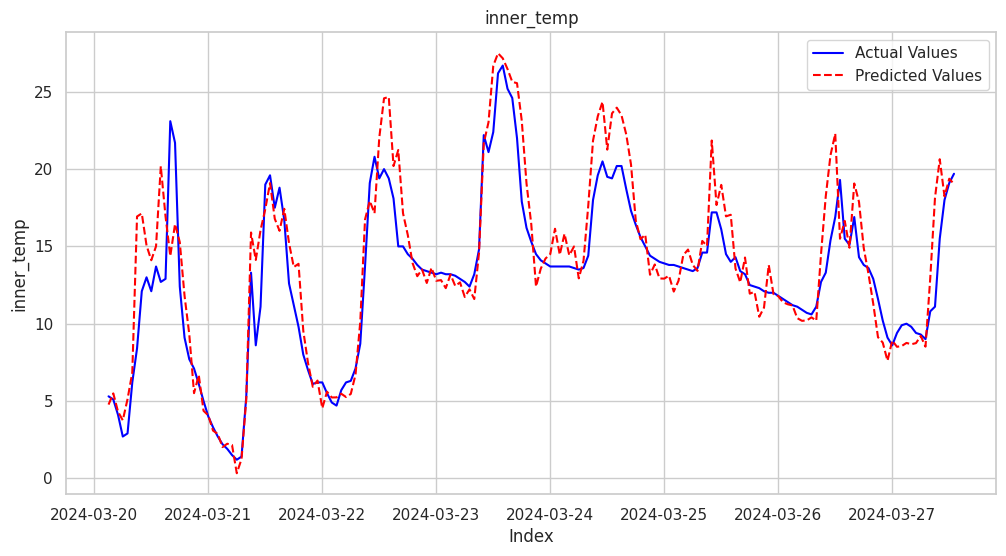

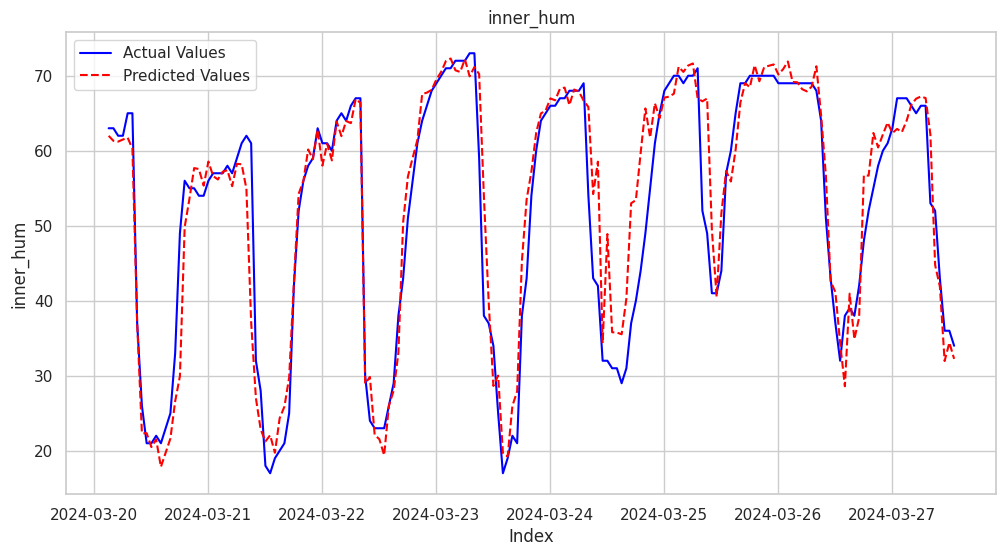

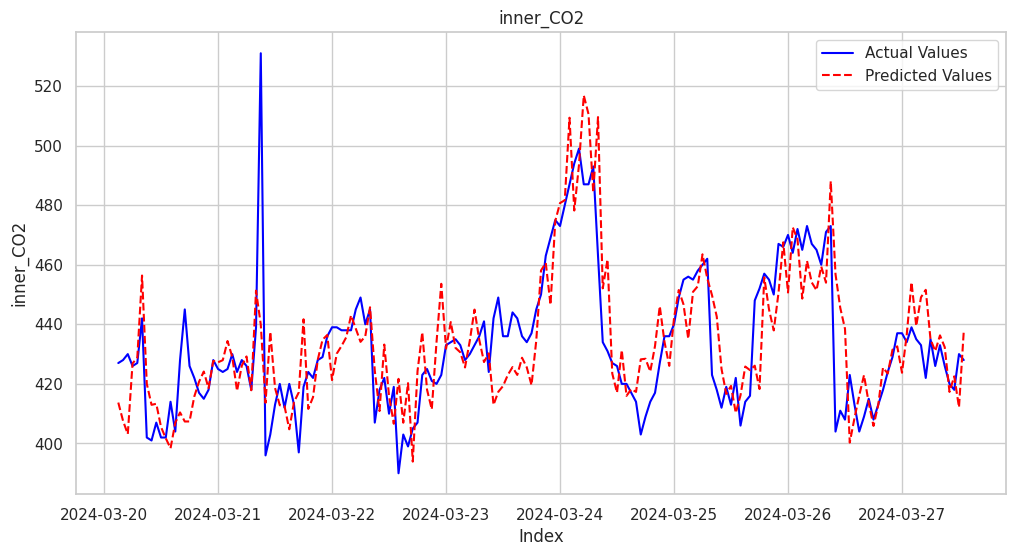

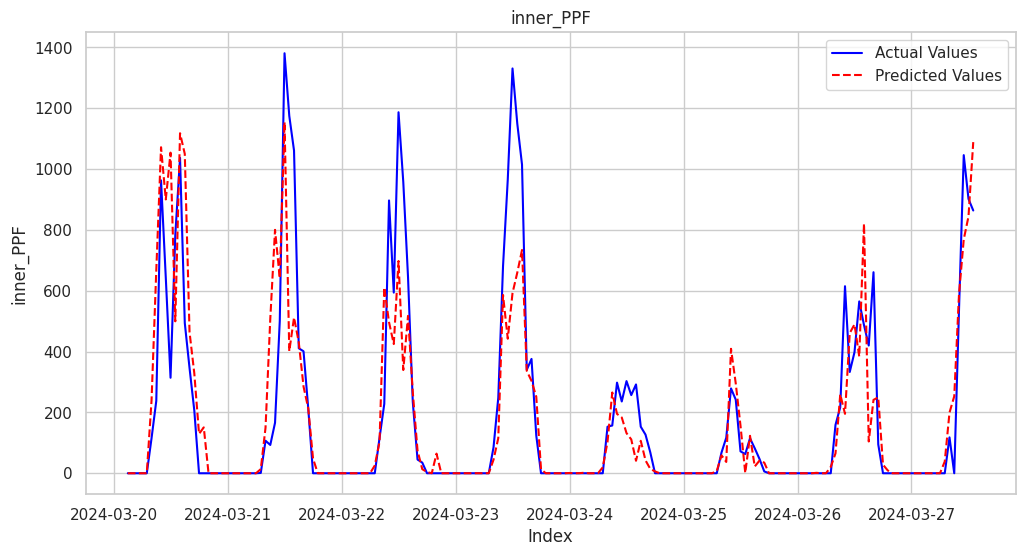

In [14]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# 변수 설정
out_columns = [col for col in test_data.columns if 'out' in col]
shifted_columns = [col for col in test_data.columns if 'shifted' in col]
input_columns = out_columns + shifted_columns
dummies_results = pd.DataFrame(index=test_data.index)

# 각 타겟 변수에 예측
for column in inner_columns:
    model_filename = f'model_{column}_dummies.pkl'
    loaded_model = joblib.load(model_filename)
    dummies_results[column] = loaded_model.predict(test_data[input_columns])

# 시각화
sns.set(style="whitegrid")

def plot_predictions(true_values, predicted_values, column_name):
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=true_values.index, y=true_values, label='Actual Values', color='blue', linestyle='-')
    sns.lineplot(x=predicted_values.index, y=predicted_values, label='Predicted Values', color='red', linestyle='--')
    plt.title(f'{column_name}')
    plt.ylabel(column_name)
    plt.xlabel('Index')
    plt.legend()
    plt.grid(True)
    plt.show()

for column in inner_columns:
    plot_predictions(test_data[column], dummies_results[column], column)


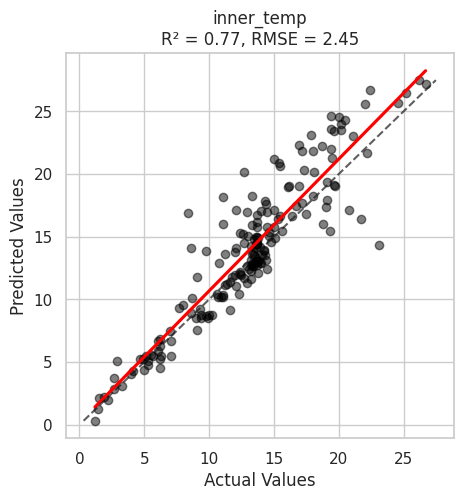

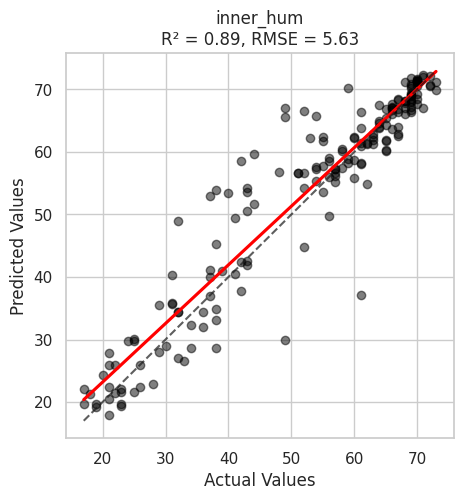

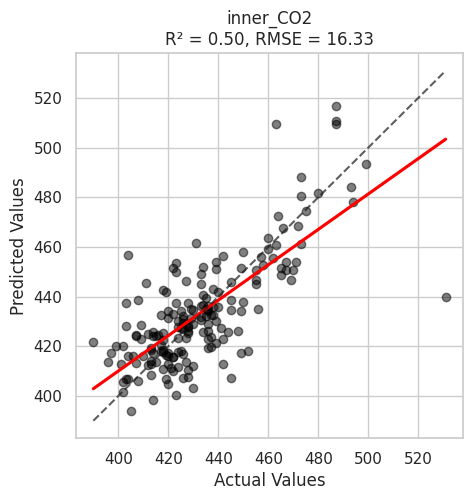

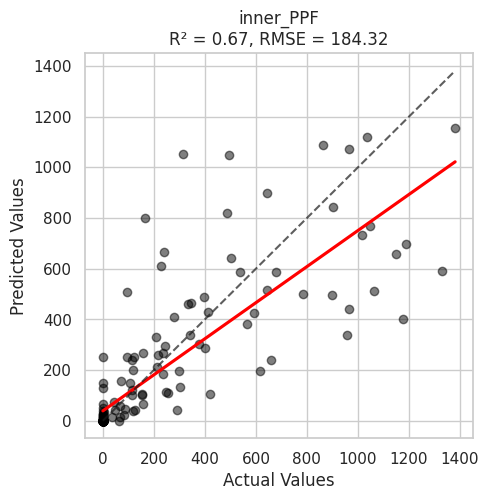

In [15]:
import pandas as pd
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 변수 설정
out_columns = [col for col in test_data.columns if 'out' in col]
shifted_columns = [col for col in test_data.columns if 'shifted' in col]
input_columns = out_columns + shifted_columns

for column in inner_columns:
    model_filename = f'model_{column}_dummies.pkl'
    loaded_model = joblib.load(model_filename)
    dummies_results[column] = loaded_model.predict(test_data[input_columns])

# 시각화 설정
sns.set(style="whitegrid")

def plot_predictions_with_regression(true_values, predicted_values, column_name):
    r2 = r2_score(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))

    plt.figure(figsize=(5, 5))
    sns.regplot(x=true_values, y=predicted_values, scatter_kws={'color': 'black', 'alpha': 0.5},
                line_kws={'color': 'red'}, ci=None)

    max_val = max(true_values.max(), predicted_values.max())
    min_val = min(true_values.min(), predicted_values.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7)

    plt.title(f'{column_name}\nR² = {r2:.2f}, RMSE = {rmse:.2f}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    plt.grid(True)
    plt.show()

for column in inner_columns:
    plot_predictions_with_regression(test_data[column], dummies_results[column], column)

# 모델 종합 평가

## 결과 후처리 및 통합

In [16]:
import pandas as pd

## 결과 후처리
lstm = lstm_results.reset_index()
lstm = lstm.rename(columns={'Predicted_inner_temp':'inner_temp_lstm',	'Predicted_inner_hum':'inner_hum_lstm',	'Predicted_inner_CO2':'inner_CO2_lstm',	'Predicted_inner_PPF':'inner_PPF_lstm'})

total_results = pd.merge(lstm, prophet_results, left_on='Date&Time', right_on='ds').drop(columns='ds')

ml = ml_results.reset_index()
ml = ml.rename(columns={'inner_temp':'inner_temp_ml',	'inner_hum':'inner_hum_ml',	'inner_CO2':'inner_CO2_ml',	'inner_PPF':'inner_PPF_ml'})

dummies = dummies_results.reset_index()
dummies = dummies.rename(columns={'inner_temp':'inner_temp_dummies',	'inner_hum':'inner_hum_dummies',	'inner_CO2':'inner_CO2_dummies',	'inner_PPF':'inner_PPF_dummies'})

total_results = pd.merge(total_results, ml, on='Date&Time')
total_results = pd.merge(total_results, dummies, on='Date&Time')
total_results

Date&Time  Actual_inner_temp  Actual_inner_hum  \
0   2024-03-20 06:00:00                2.7              62.0   
1   2024-03-20 07:00:00                2.9              65.0   
2   2024-03-20 08:00:00                6.2              65.0   
3   2024-03-20 09:00:00                8.4              37.0   
4   2024-03-20 10:00:00               12.1              26.0   
..                  ...                ...               ...   
171 2024-03-27 09:00:00               11.1              52.0   
172 2024-03-27 10:00:00               15.5              43.0   
173 2024-03-27 11:00:00               18.0              36.0   
174 2024-03-27 12:00:00               19.1              36.0   
175 2024-03-27 13:00:00               19.7              34.0   

     Actual_inner_CO2  Actual_inner_PPF  inner_temp_lstm  inner_hum_lstm  \
0               426.0               0.0         5.854596       63.138252   
1               427.0               0.0         4.326275       62.815598   
2               442.0             115.0         4.531692       64.064064   
3               402.0             238.0        13.622413       49.937016   
4               401.0             963.0        14.670341       30.861240   
..                ...               ...              ...             ...   
171             426.0               0.0        15.631771       47.482315   
172             420.0             536.0        13.333271       50.027096   
173             418.0            1046.0        20.421549       30.130619   
174             430.0             902.0        19.713722       29.298162   
175             428.0             864.0        22.166800       28.905827   

     inner_CO2_lstm  inner_PPF_lstm  inner_temp_yhat  ...  \
0        430.121033        4.212881         5.766404  ...   
1        428.984283        0.097865         6.359518  ...   
2        430.184326       24.168425         8.103171  ...   
3        438.238251      369.805359        10.755332  ...   
4        413.440002      545.787292        13.600159  ...   
..              ...             ...              ...  ...   
171      428.965149      329.532684        11.004687  ...   
172      418.640411      259.325226        13.849514  ...   
173      443.626892     1014.031250        16.153550  ...   
174      423.248871      739.347961        17.564553  ...   
175      426.809296     1096.615112        18.143261  ...   

     inner_PPF_yhat_lower  inner_PPF_yhat_upper  inner_temp_ml  inner_hum_ml  \
0             -157.882334            265.951321          3.735         59.34   
1             -135.304320            277.124086          8.065         59.17   
2              -38.565013            366.291153          9.735         53.64   
3              106.834144            519.197102         16.992         38.55   
4              227.323378            644.009870         21.659         24.37   
..                    ...                   ...            ...           ...   
171            100.574541            529.243325         21.910         46.65   
172            258.536191            673.274274         18.909         38.20   
173            350.050810            768.293863         20.116         32.66   
174            351.503253            779.557487         22.491         36.99   
175            297.044566            726.201090         24.733         34.27   

     inner_CO2_ml  inner_PPF_ml  inner_temp_dummies  inner_hum_dummies  \
0          439.20          0.00               3.750              61.50   
1          432.23          0.00               5.118              61.74   
2          446.65        199.43               6.845              60.27   
3          421.93        266.48              16.934              37.04   
4          427.15        356.79              17.134              22.33   
..            ...           ...                 ...                ...   
171        459.33        405.85              18.144              44.77   
172        423.21        767.96              2

## 모델별 결과 비교

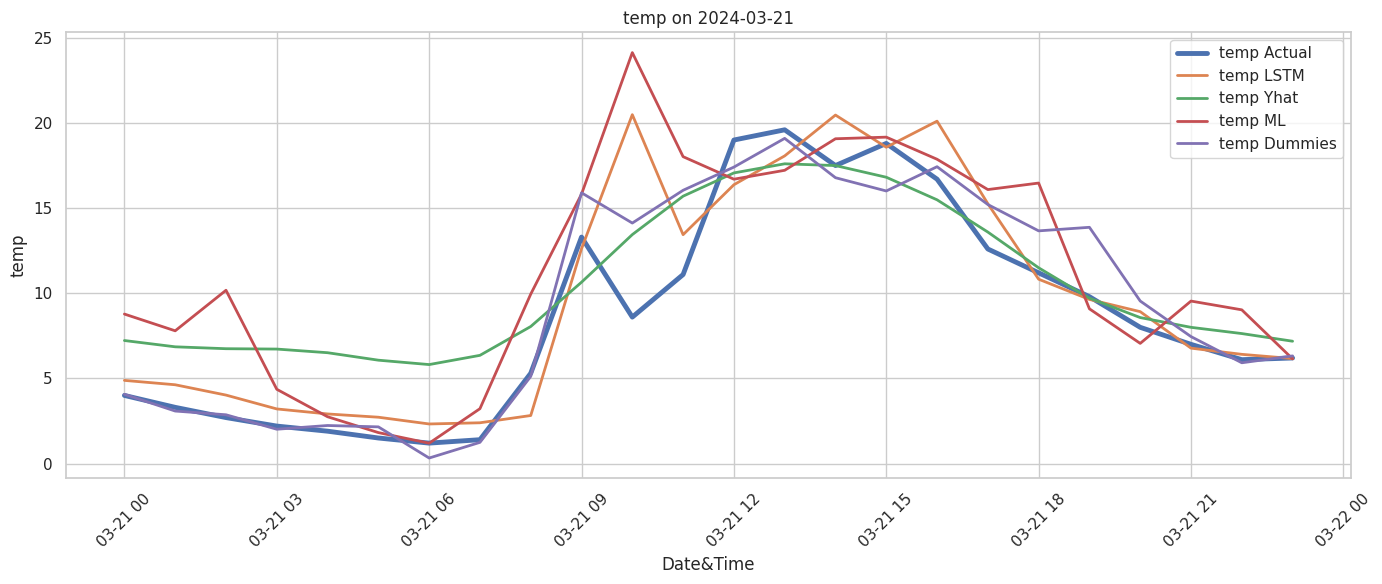

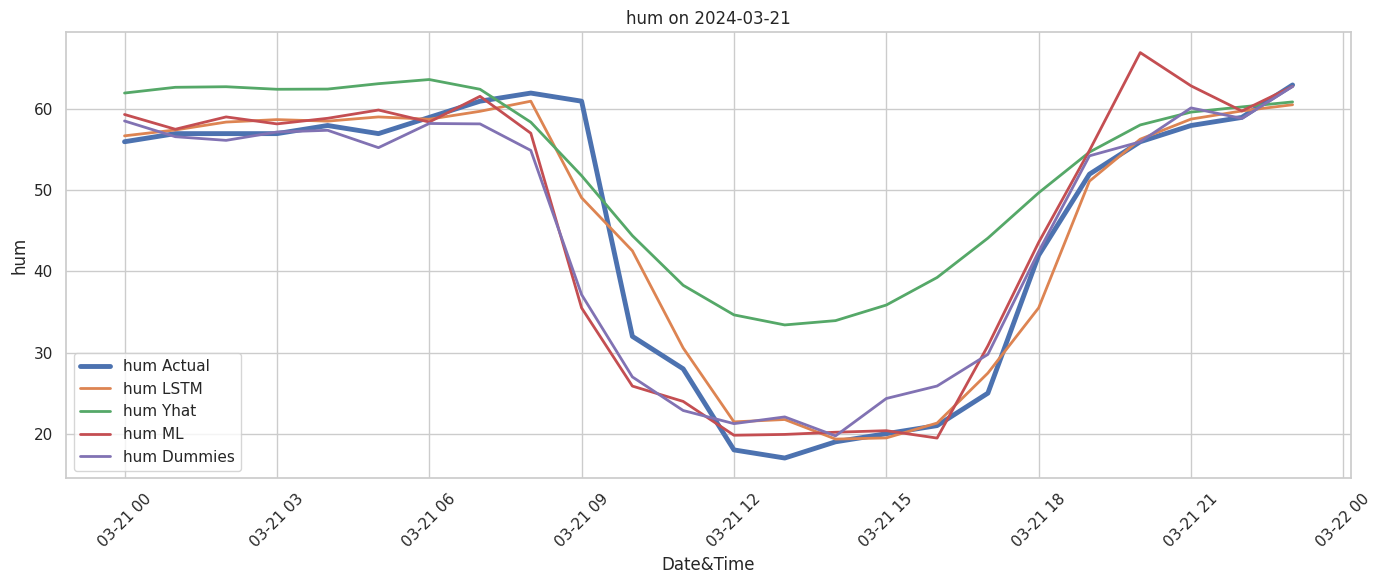

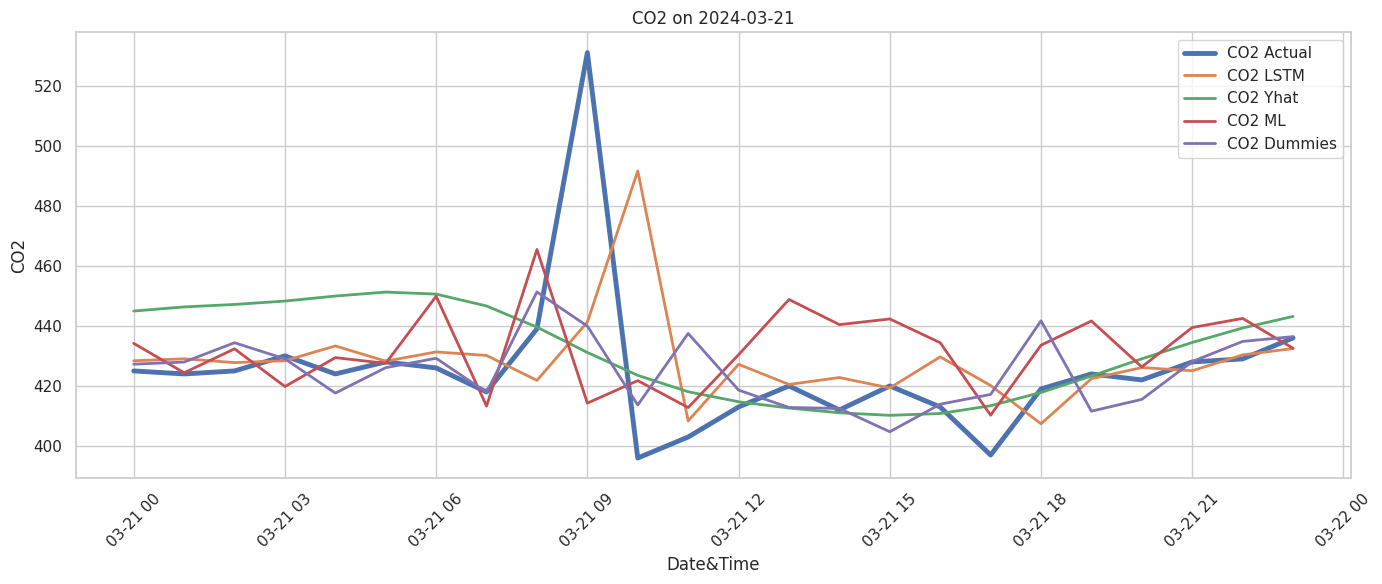

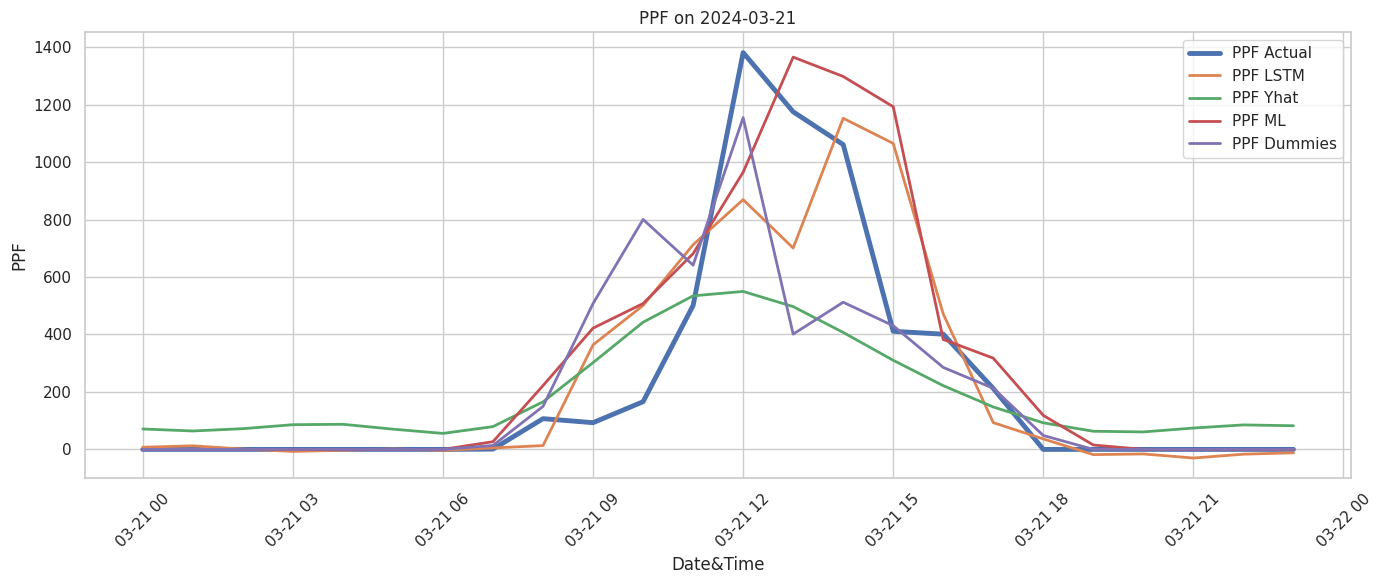

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# 각 변수에 대한 컬럼 리스트
variables = ['temp', 'hum', 'CO2', 'PPF']

sns.set(style="whitegrid")

random_date = random.choice(pd.to_datetime(total_results['Date&Time']).dt.date.unique())
daily_data = total_results[pd.to_datetime(total_results['Date&Time']).dt.date == random_date]

# 플롯을 변수별로 그리기
for var in variables:
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=daily_data, x='Date&Time', y=f'Actual_inner_{var}', label=f'{var} Actual', linewidth=3.5)
    sns.lineplot(data=daily_data, x='Date&Time', y=f'inner_{var}_lstm', label=f'{var} LSTM', linewidth=2)
    sns.lineplot(data=daily_data, x='Date&Time', y=f'inner_{var}_yhat', label=f'{var} Prophet', linewidth=2)
    sns.lineplot(data=daily_data, x='Date&Time', y=f'inner_{var}_ml', label=f'{var} ML', linewidth=2)
    sns.lineplot(data=daily_data, x='Date&Time', y=f'inner_{var}_dummies', label=f'{var} Dummies', linewidth=2)

    plt.xlabel('Date&Time')
    plt.ylabel(f'{var}')
    plt.title(f'{var} on {random_date}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
